<font size='10'>**About Dataset**</font>

The dataset refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories

Source: Kaggle ( you can click [**here**](https://www.kaggle.com/datasets/binovi/wholesale-customers-data-set/data) for more information)

<font size='10'>**Data Description**</font>

The dataset includes 8 columns:
- Channel - Horeca (Hotel/Restaurant/Cafe or Retail channel (Nominal)
- Regions - Lisnon, Oporto or Other (Nominal)
- Fresh - annual spending (m.u.) on fresh products (Continuous)
- Milk - annual spending (m.u.) on milk products (Continuous)
- Grocery - annual spending (m.u.)on grocery products (Continuous)
- Frozen - annual spending (m.u.)on frozen products (Continuous)
- Detergents_Paper - annual spending (m.u.) on detergents and paper products (Continuous)
- Delicassen - annual spending (m.u.)on and delicatessen products (Continuous)

<font size='10'>Objective</font>

Find the optimal model (focus on clustering) to cluster the given dataset 

<font size='10'>Outline</font>

1. Import Libraries
2. Data Overview
3. EDA
4. Feature Engineering
5. Modeling 

<font size='10'>Import Libraries</font>

In [29]:
# basics
import os
import zipfile
import numpy as np
import pandas as pd

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.model_selection import train_test_split,KFold,GridSearchCV
from  sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

<font size='10'>Unzip the file</font>

In [2]:
# with zipfile.ZipFile("dataset.zip") as zipp:
#     zipp.extractall()

In [3]:
# # push extracted files into a folder
# os.makedirs("Dataset")
# filenames=['Wholesale customers data.csv']
# path='Dataset'
# for file in filenames:
#     os.rename(file,os.path.join(path,file))


<font size='10'> Data Overview</font>

In [4]:
df= pd.read_csv('Dataset/Wholesale customers data.csv')
df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
def overview(dataframe: pd.DataFrame):
    d={'Datatype': dataframe.dtypes,
       'Number of values': dataframe.nunique(),
       'Any missing values': dataframe.isnull().any(),
        'Columns': dataframe.columns,
         'Index': dataframe.index,
         'Describe.T': dataframe.describe().T 
         }
    Hash_tag='*'*50

    for name, value in d.items():
        print(Hash_tag,name,Hash_tag)
        print(value)
    print(Hash_tag,"END",Hash_tag)

In [7]:
overview(df)

************************************************** Datatype **************************************************
Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object
************************************************** Number of values **************************************************
Channel               2
Region                3
Fresh               433
Milk                421
Grocery             430
Frozen              426
Detergents_Paper    417
Delicassen          403
dtype: int64
************************************************** Any missing values **************************************************
Channel             False
Region              False
Fresh               False
Milk                False
Grocery             False
Frozen              False
Detergents_Paper    False
Delicassen          False
dtype: bool
**

It is clear that:
- There are 8 columns in the dataset
- All of features in the dataset have datatype of integer
- There are no missing values in the dataset

<font size='10'>**Exploratory Data Analysis**</font>

<font size='5'>**Classify**</font>

In [8]:
def classify(dataframe,cat_th=10,car_th=20):
    cat_cols=dataframe.columns[dataframe.dtypes=="object"].tolist()
    num_cols=dataframe.columns[dataframe.dtypes!='object']

    num_but_cat=dataframe.columns[(dataframe.dtypes!='object') & (dataframe.nunique()<=cat_th)].tolist()
    cat_but_car=dataframe.columns[(dataframe.dtypes=='object') & (dataframe.nunique()>=car_th)]

    num_cols=[col for col in num_cols if col not in num_but_cat]
    cat_cols=[col for col in cat_cols if col not in cat_but_car]
    cat_cols+=num_but_cat

    print("number of columns:",dataframe.shape[1])
    print("cat_cols:",len(cat_cols))
    print("num_cols:",len(num_cols))
    print("cat but car:",len(cat_but_car))

    return cat_cols,num_cols,cat_but_car


In [9]:
cat_cols,num_cols,cat_but_car=classify(df)

number of columns: 8
cat_cols: 2
num_cols: 6
cat but car: 0


<font size='5'>**Categorical data**</font>

In [10]:
def to_analysis_cat(dataframe,col, ratio=False, plot=False):
    
    if ratio:
        print(pd.DataFrame({col: dataframe[col].value_counts(),"Ratio":dataframe[col].value_counts()/len(dataframe)}))
    if plot:
        plt.figure(figsize=(10,10))
        plt.pie(x=dataframe[col].value_counts().values,labels=dataframe[col].value_counts().index)
        plt.tight_layout()
        plt.show()    


         Channel     Ratio
Channel                   
1            298  0.677273
2            142  0.322727


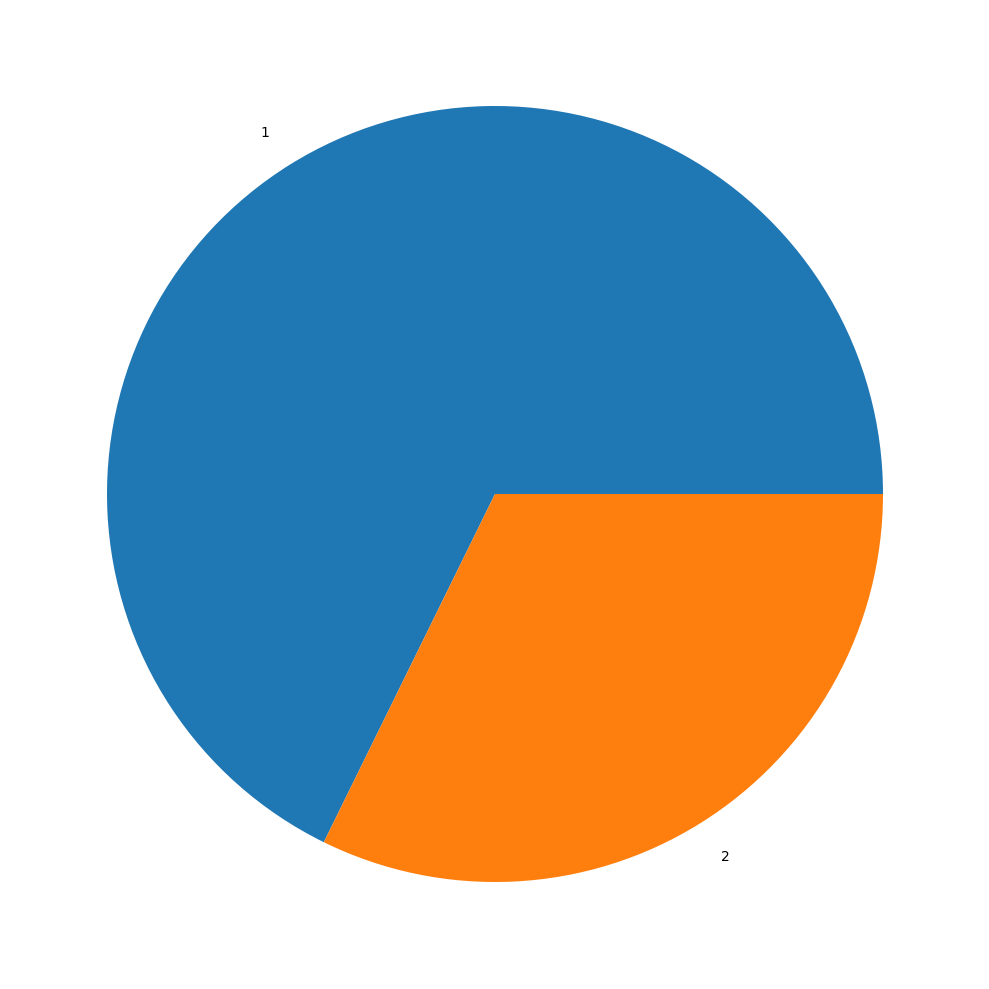

        Region     Ratio
Region                  
3          316  0.718182
1           77  0.175000
2           47  0.106818


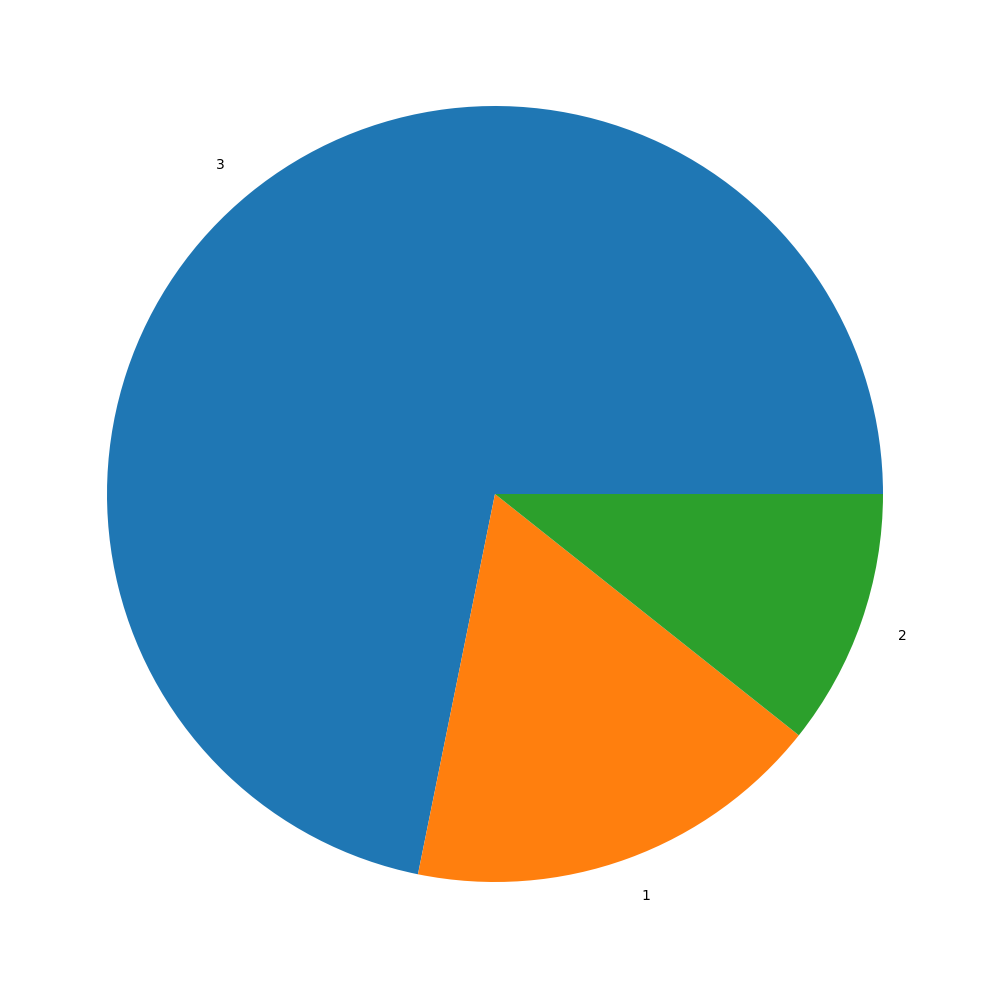

In [11]:
for col in cat_cols:
    to_analysis_cat(df,col,True,True)

**Consideration**
- ...
- ...

<font size='5'>**Numeric data**</font>

In [12]:
def to_analysis_num(dataframe, cols):
    for col in cols:
        plt.subplot(1,2,1)
        sns.histplot(data=dataframe, x=col, bins=40)
        
        plt.subplot(1,2,2)
        sns.boxplot(data=dataframe,x=col)
        plt.tight_layout()
        plt.show()
    


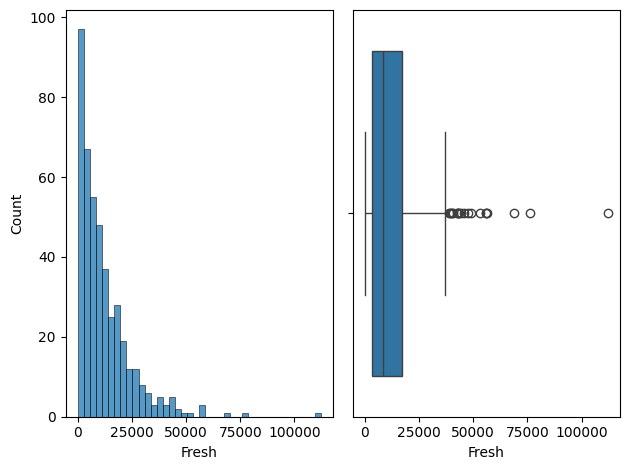

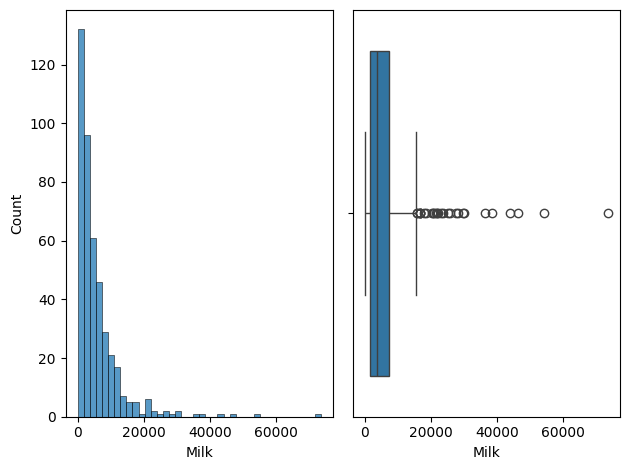

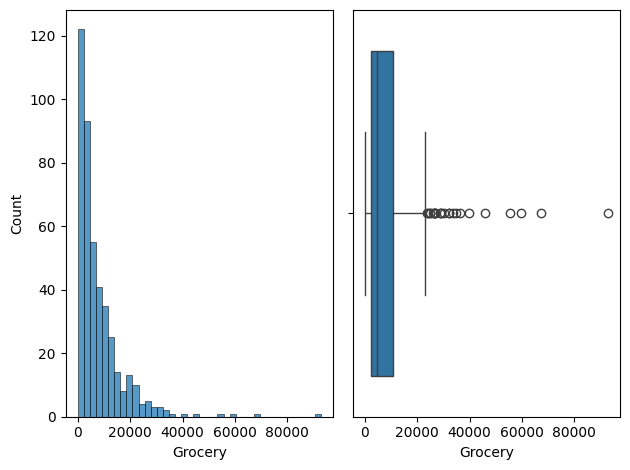

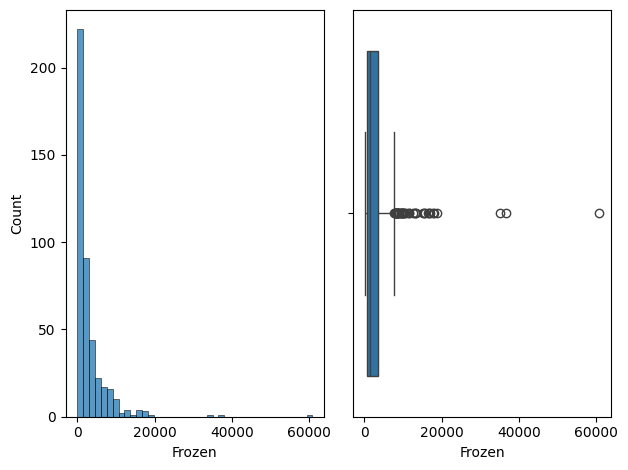

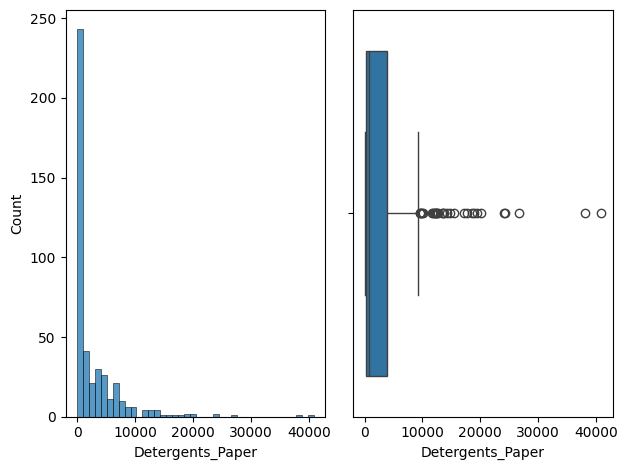

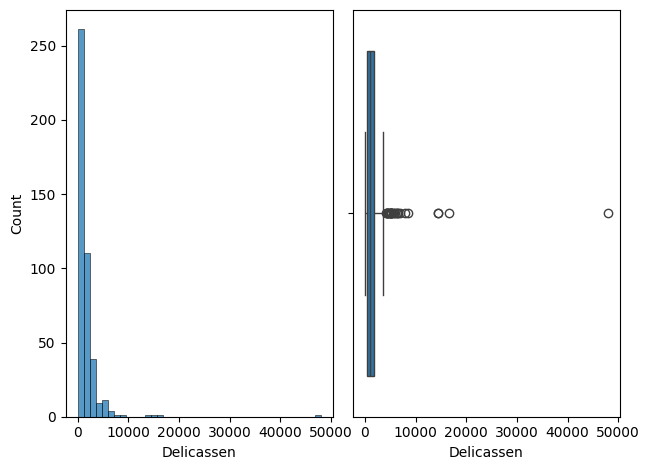

In [13]:
to_analysis_num(df,num_cols)

**Relationship between numeric variables**

<Axes: >

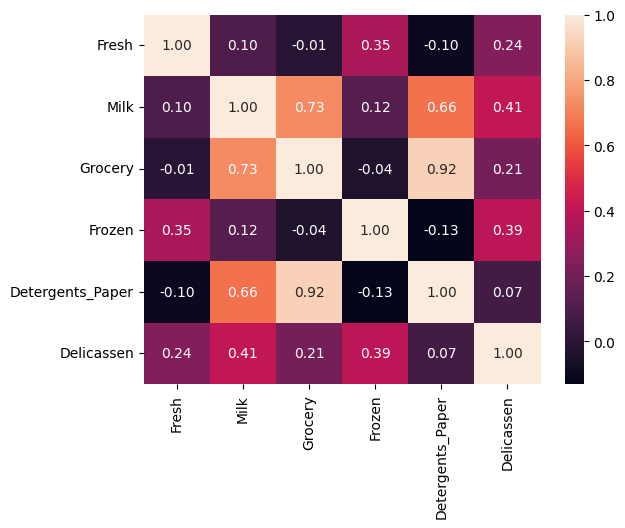

In [14]:
corr= df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f')



**Consideration**
- ..
- ..

<font size='5'>**Cat vs Num variables**<font>

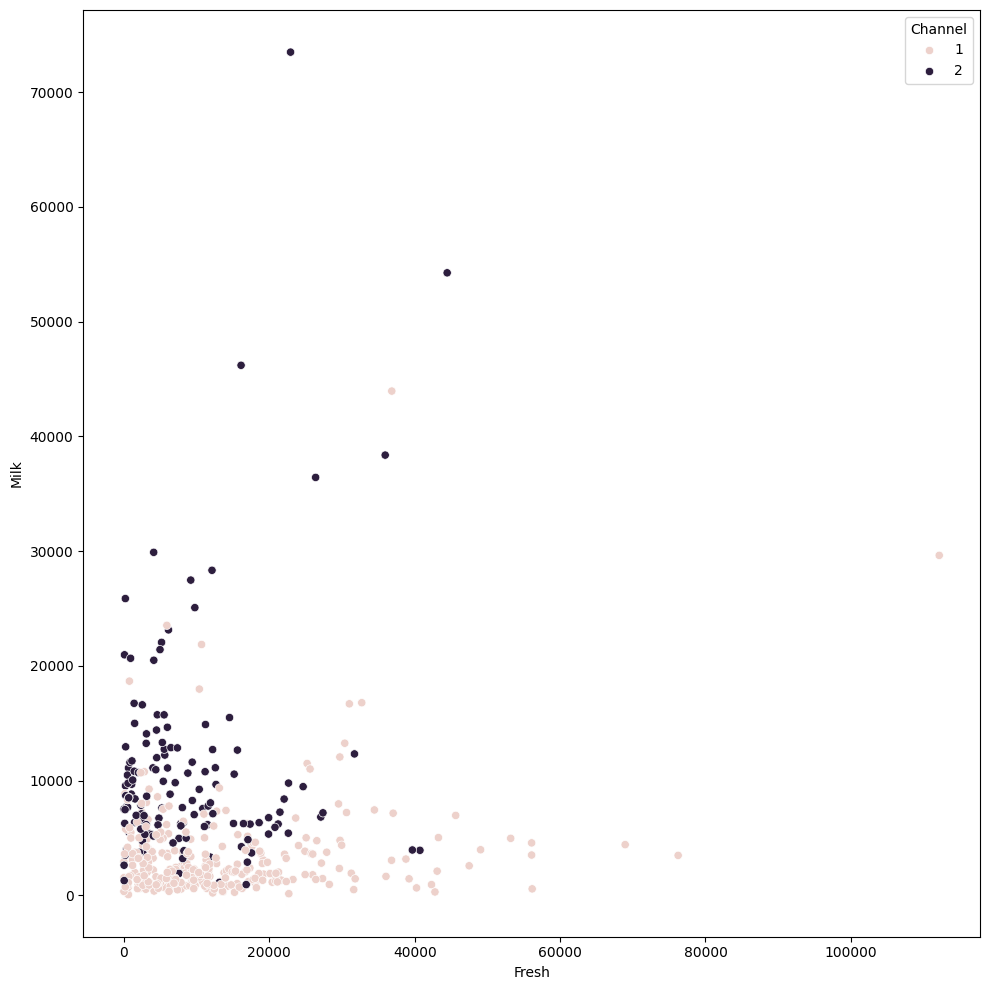

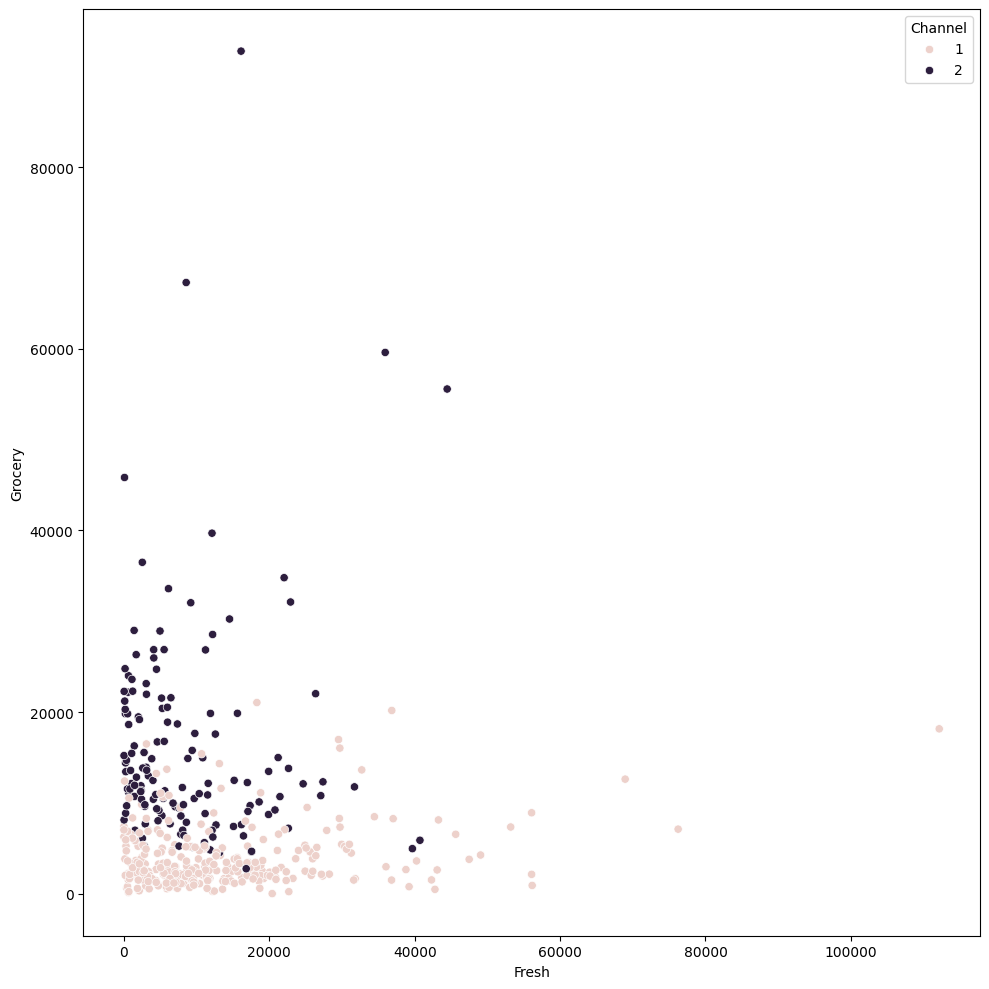

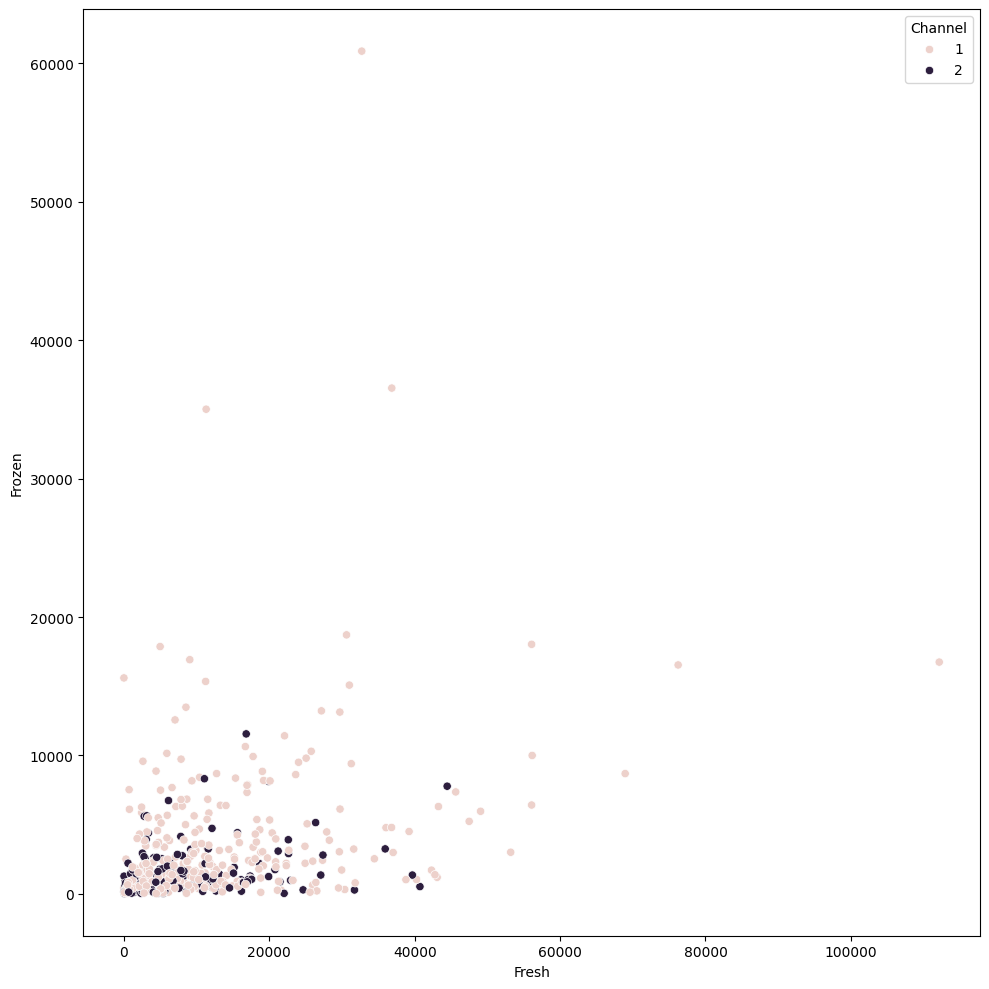

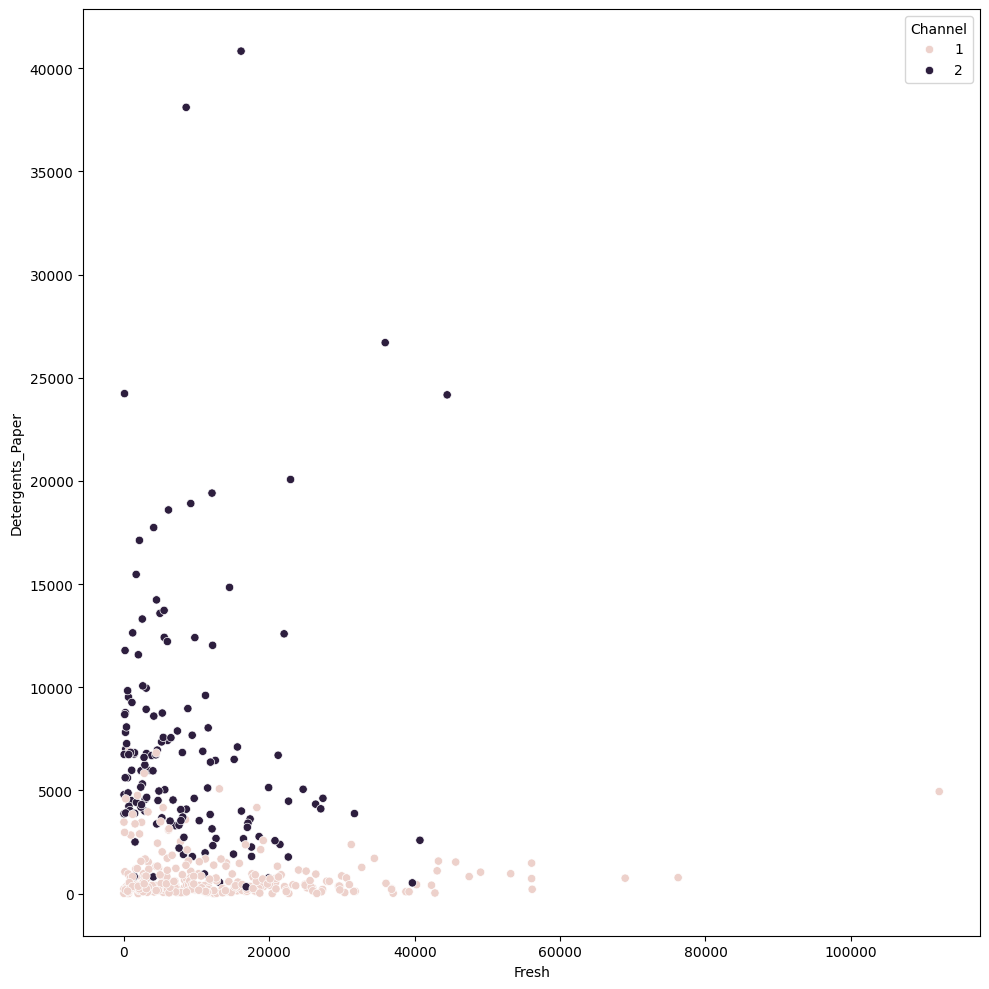

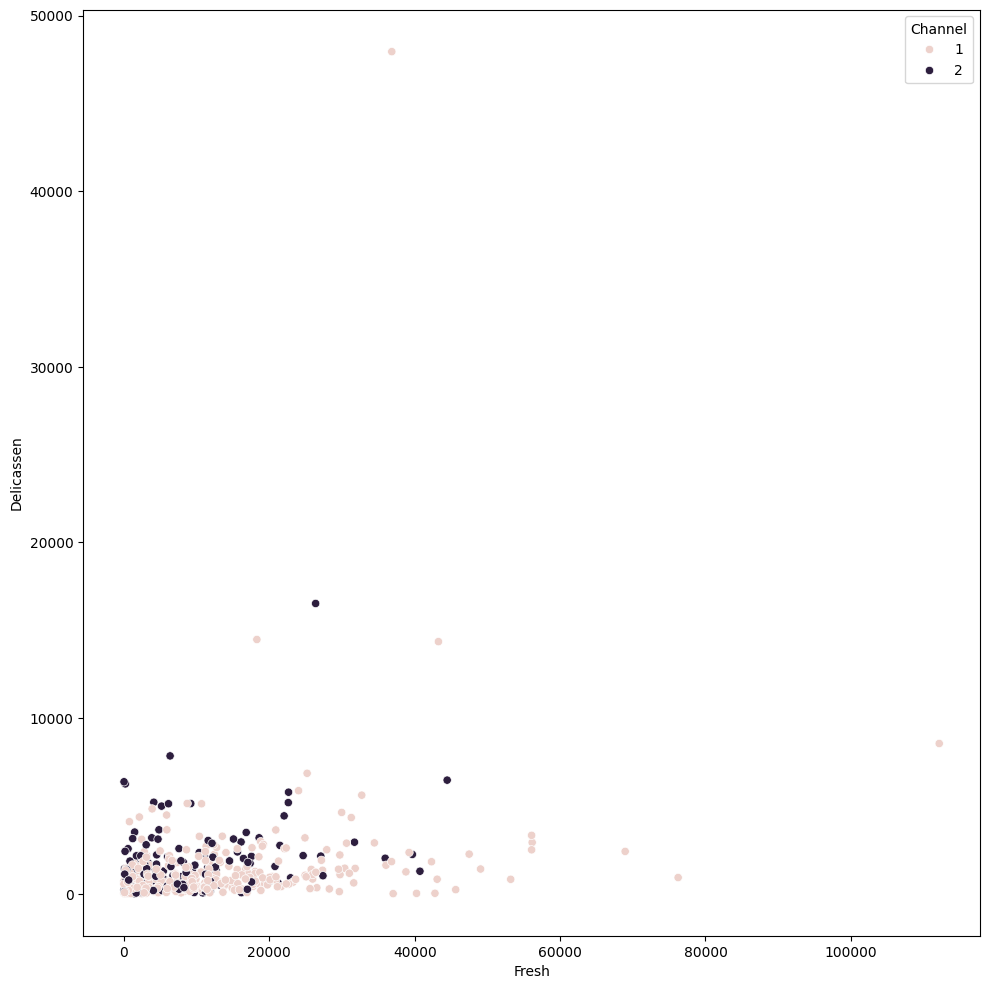

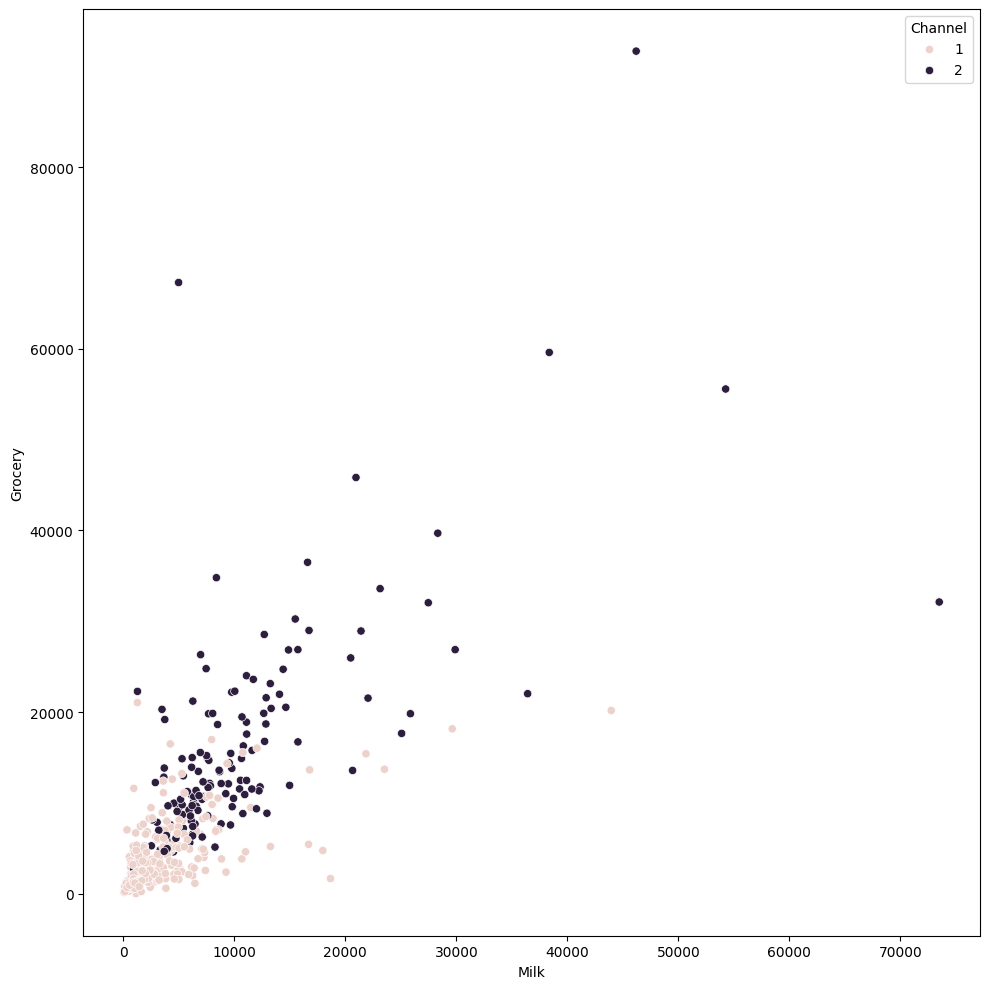

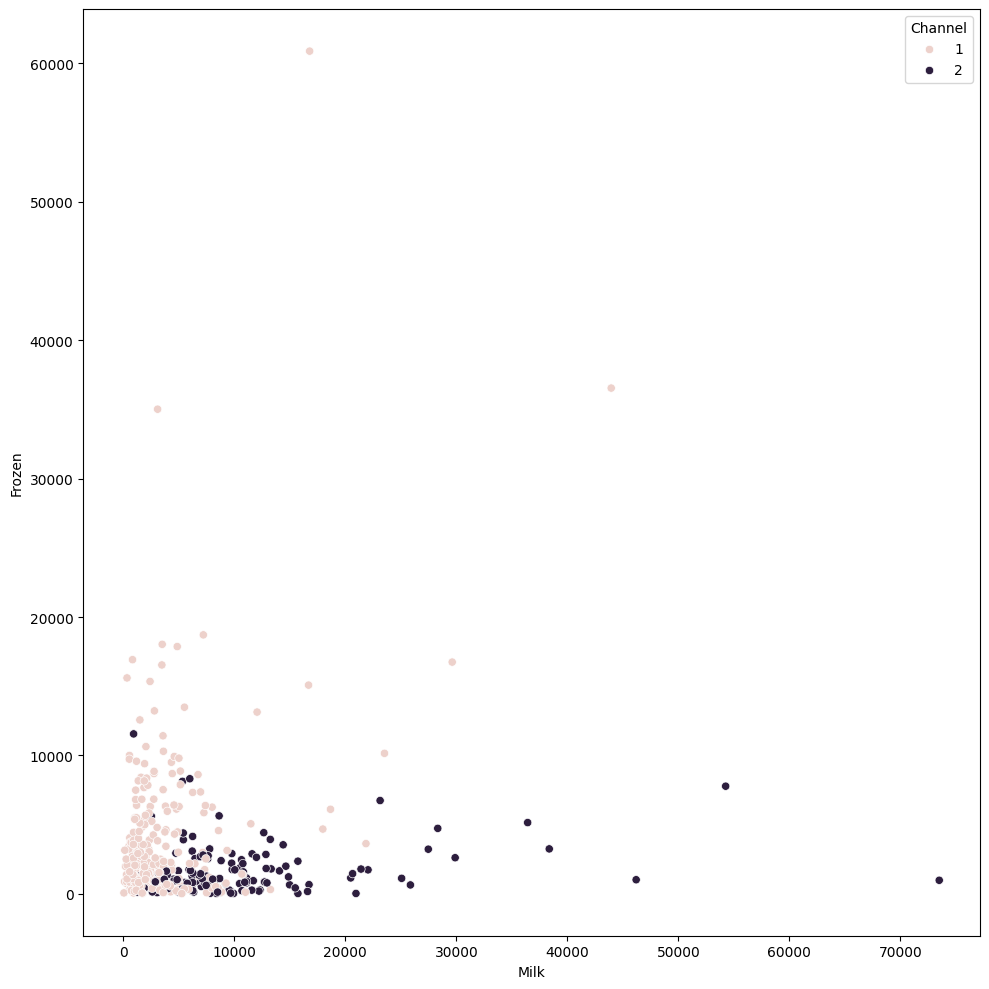

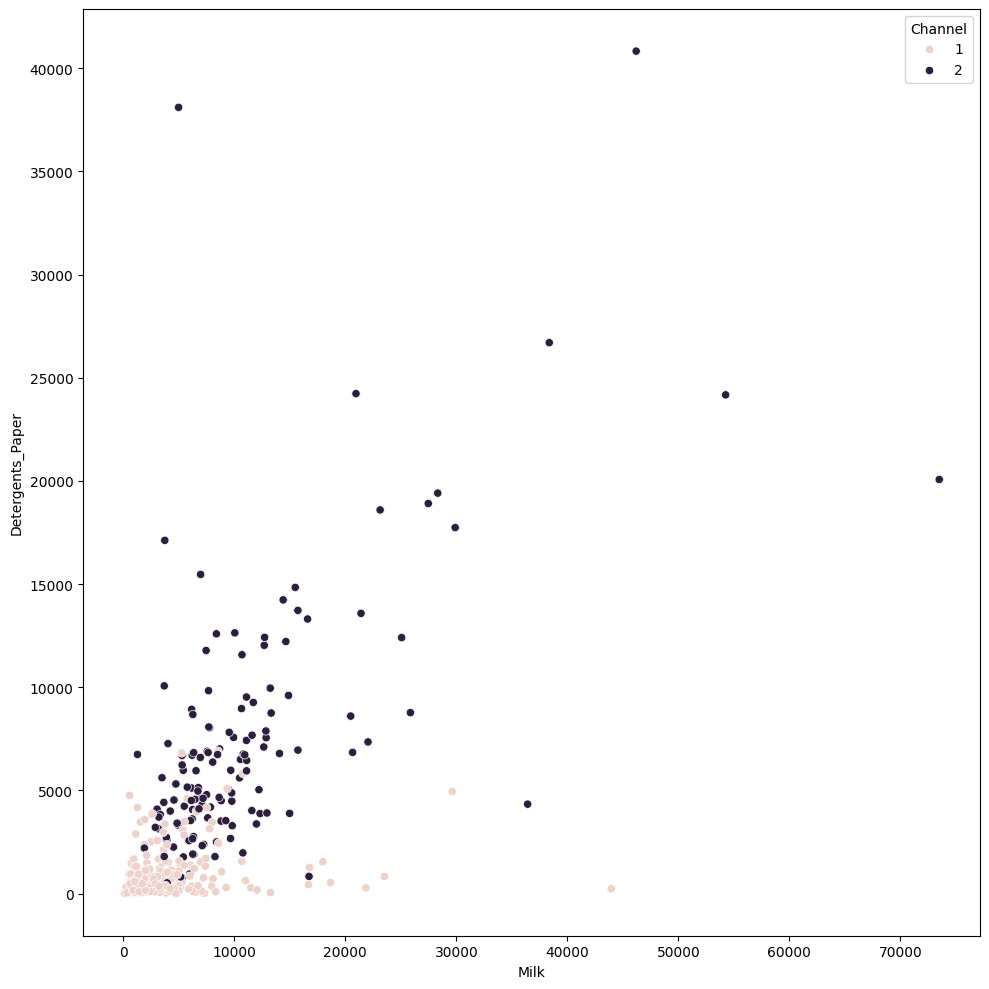

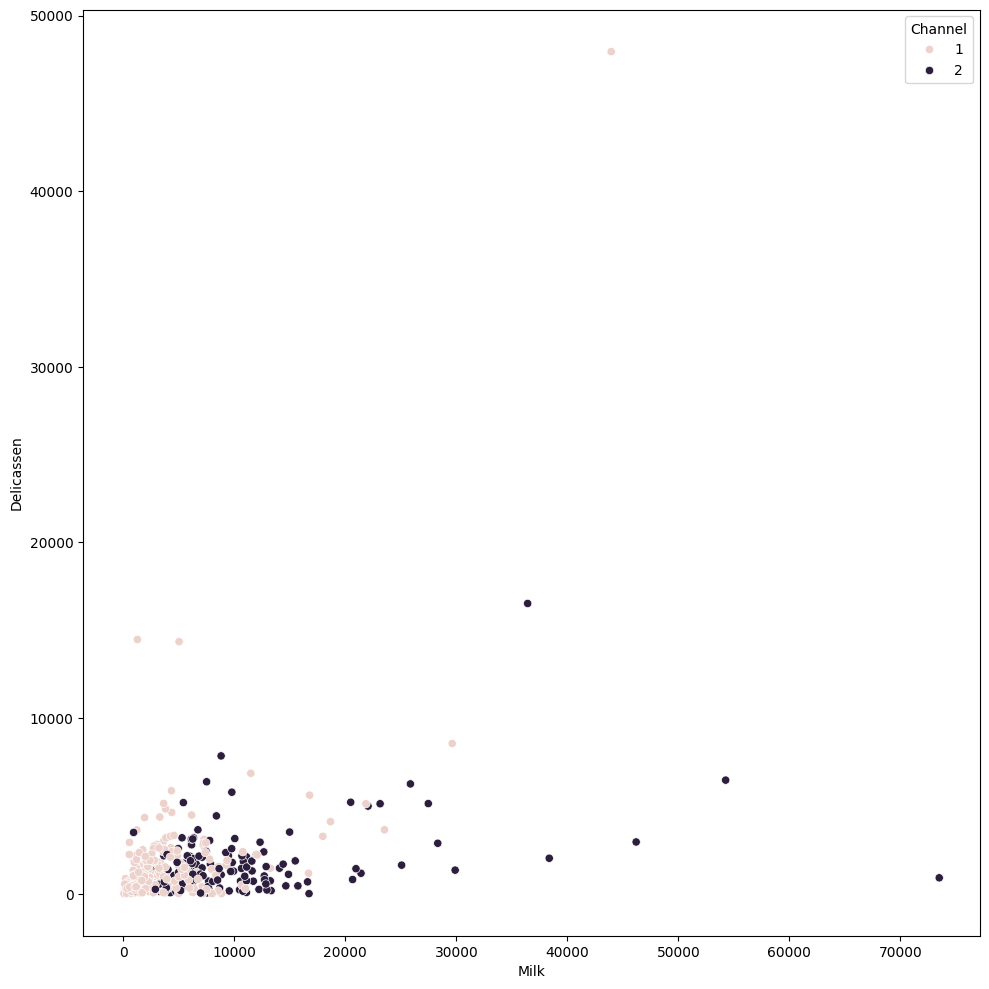

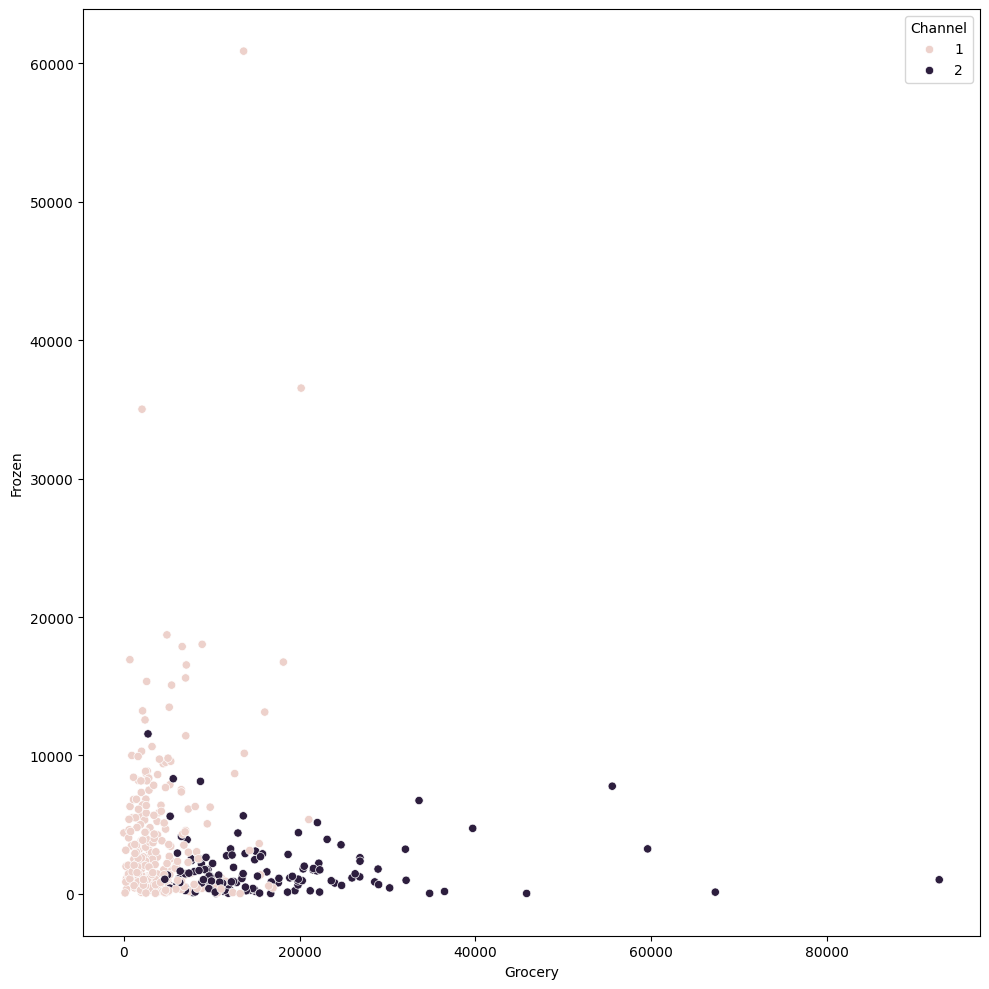

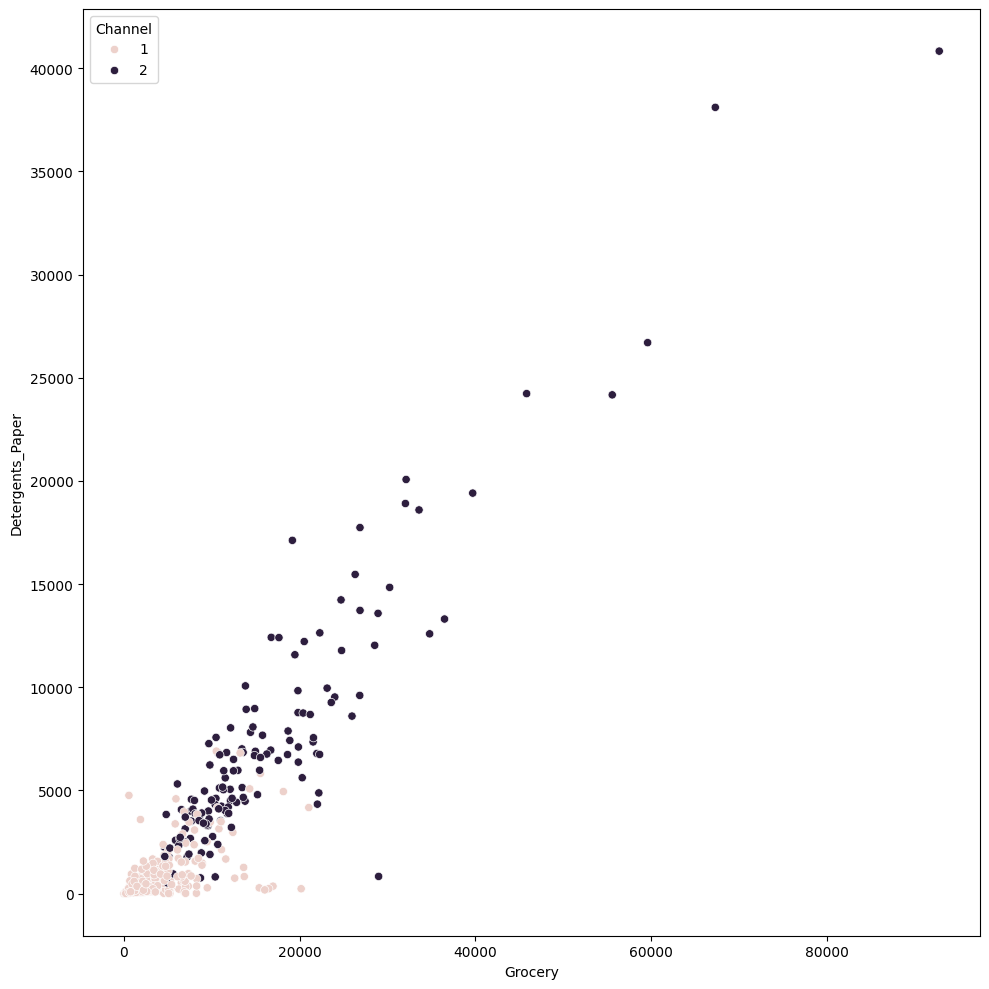

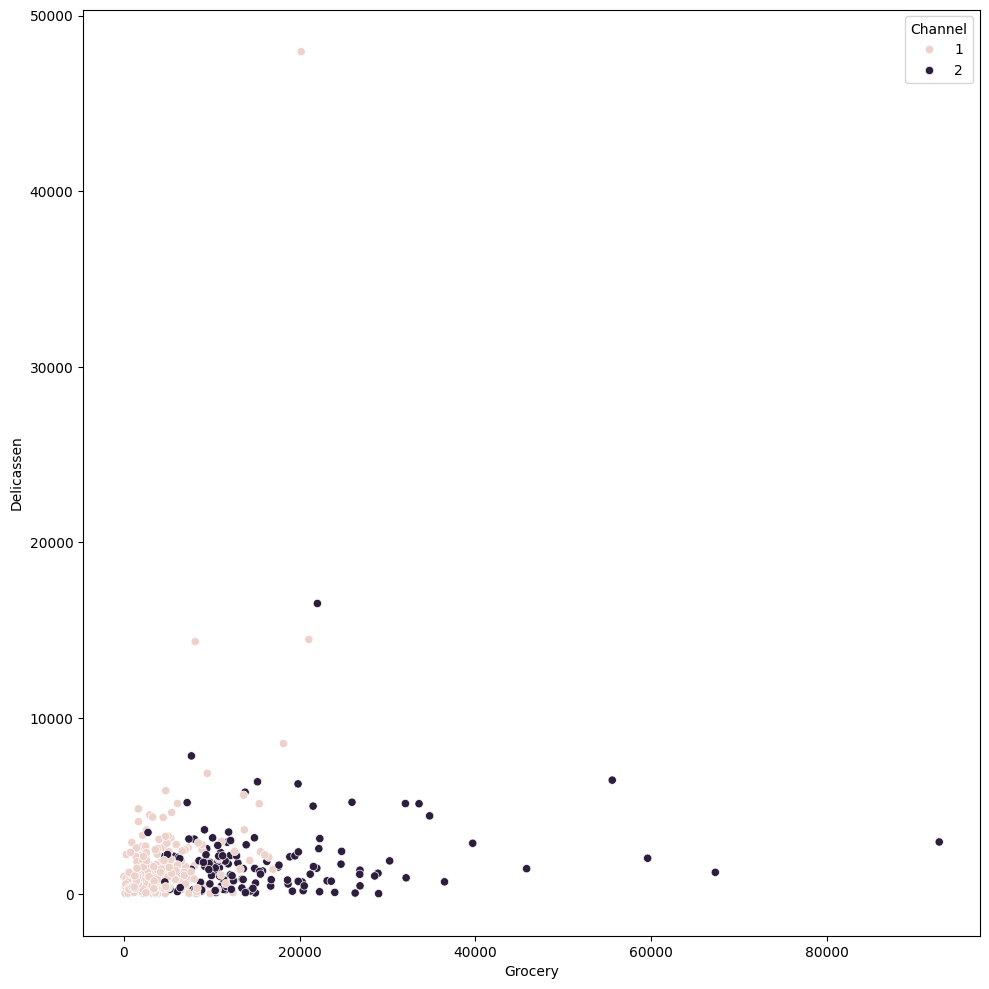

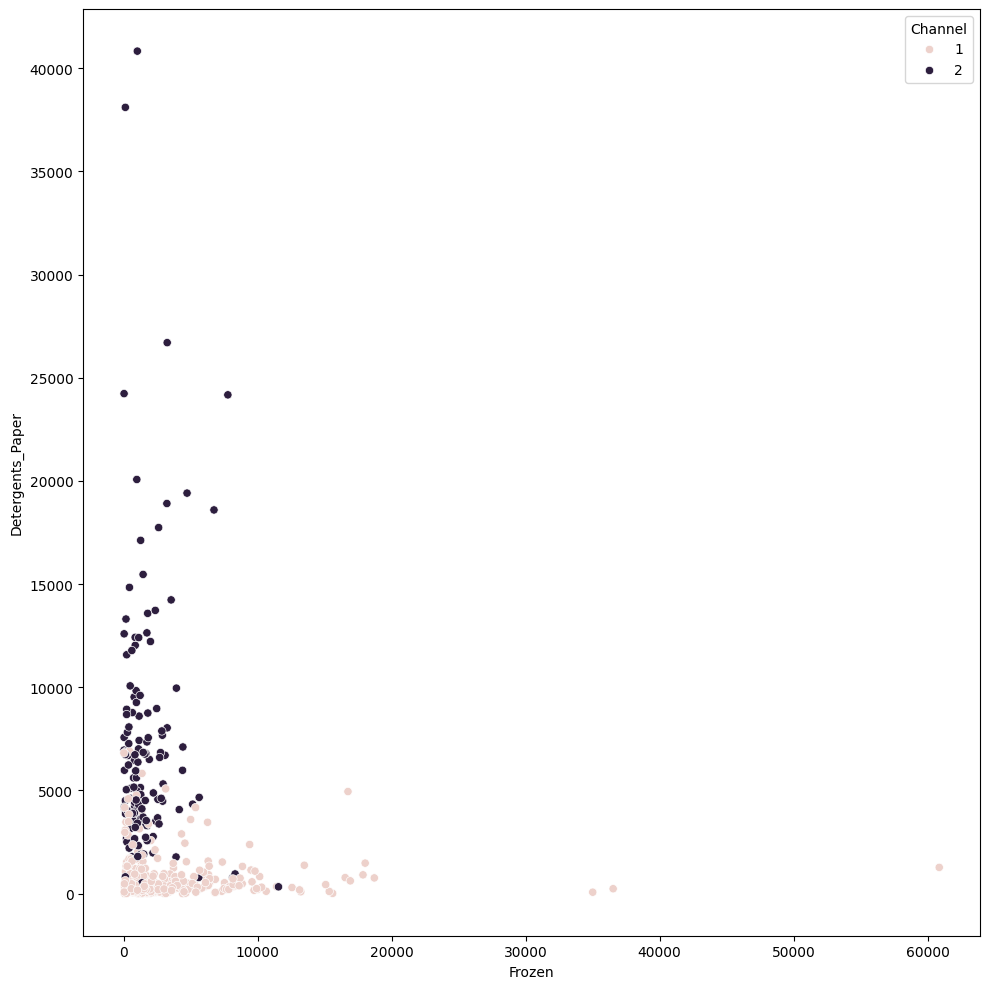

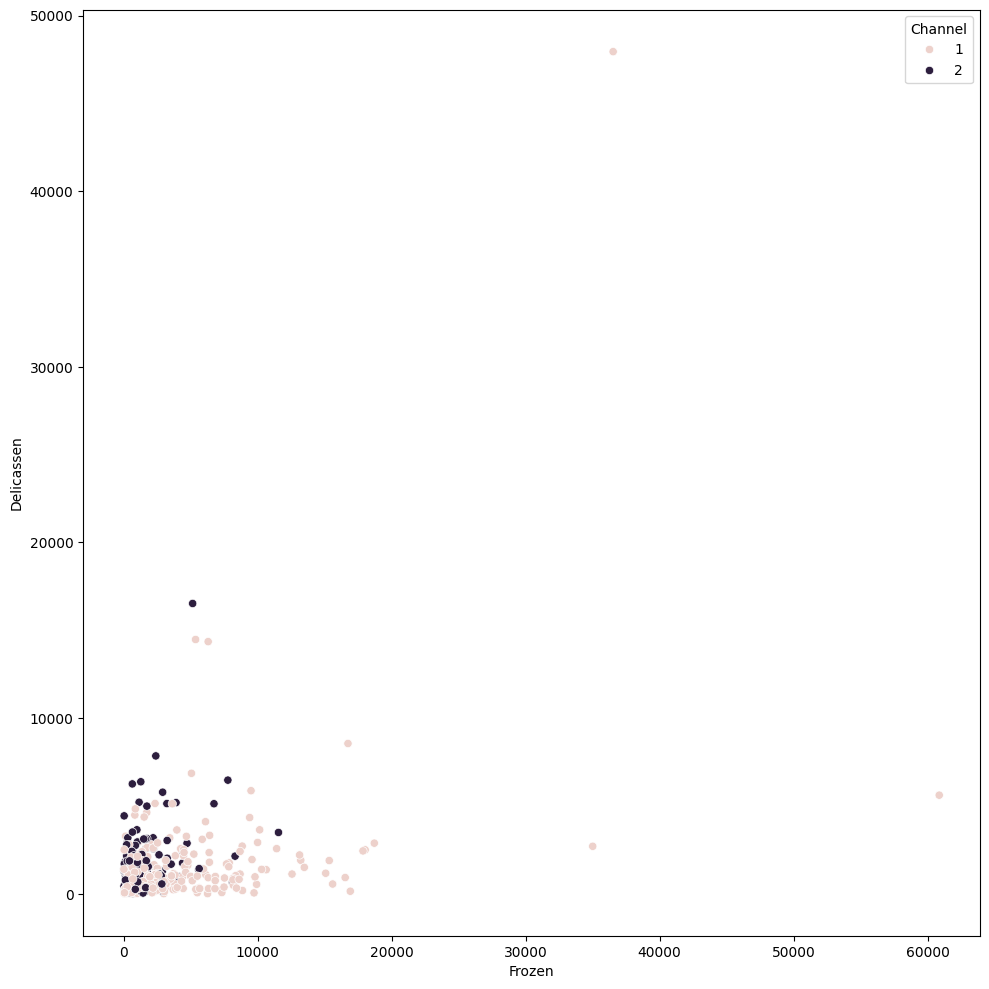

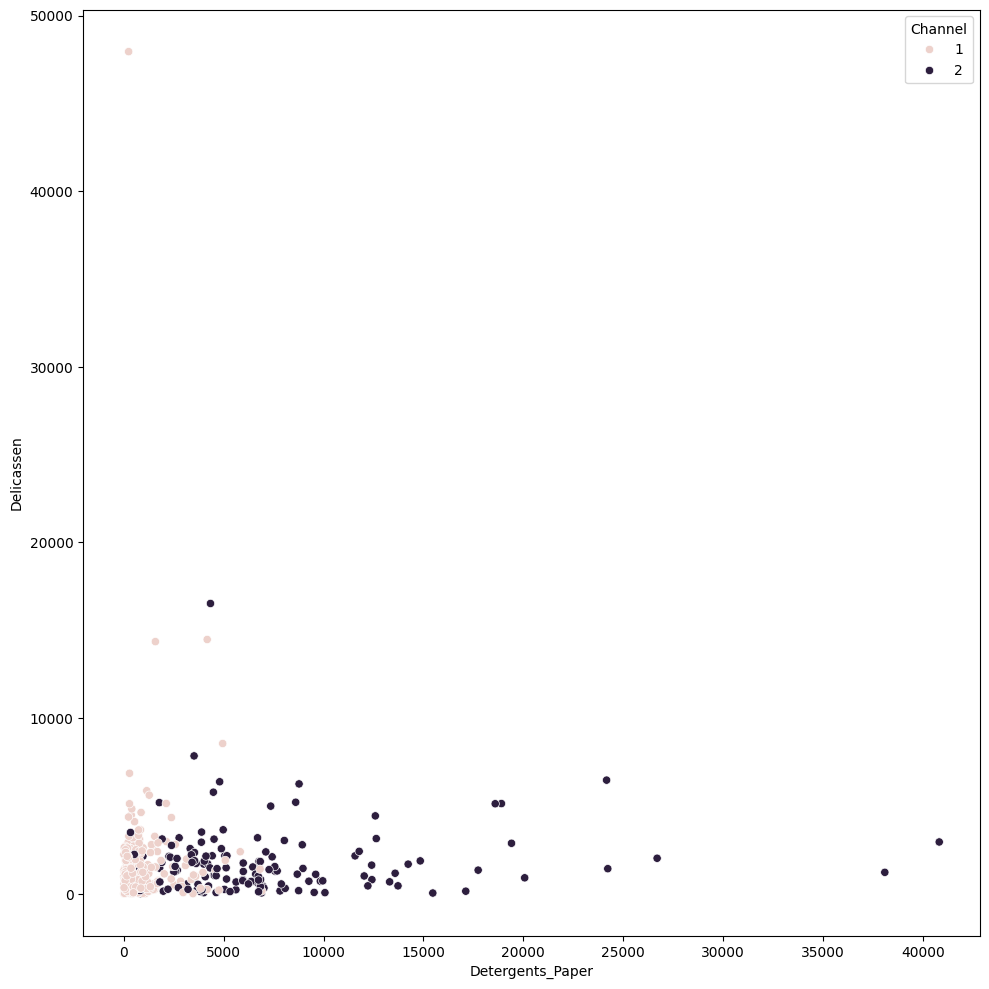

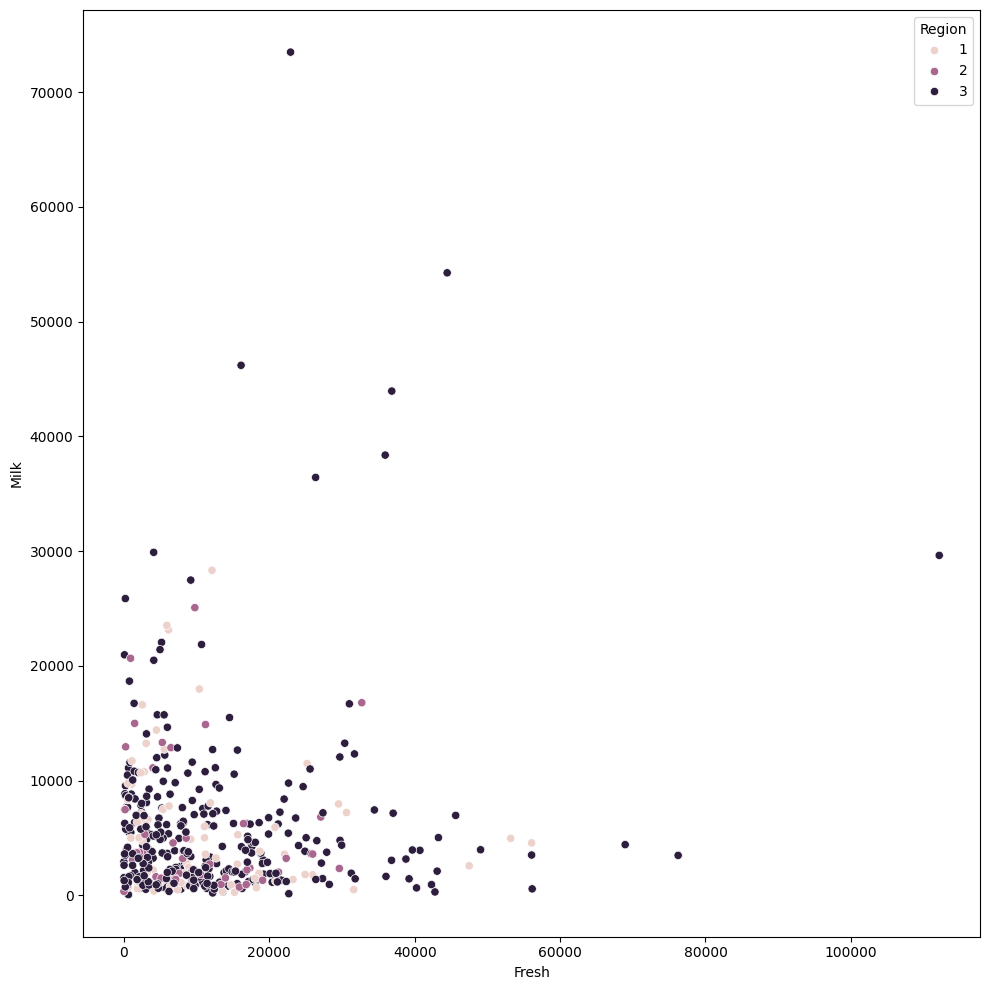

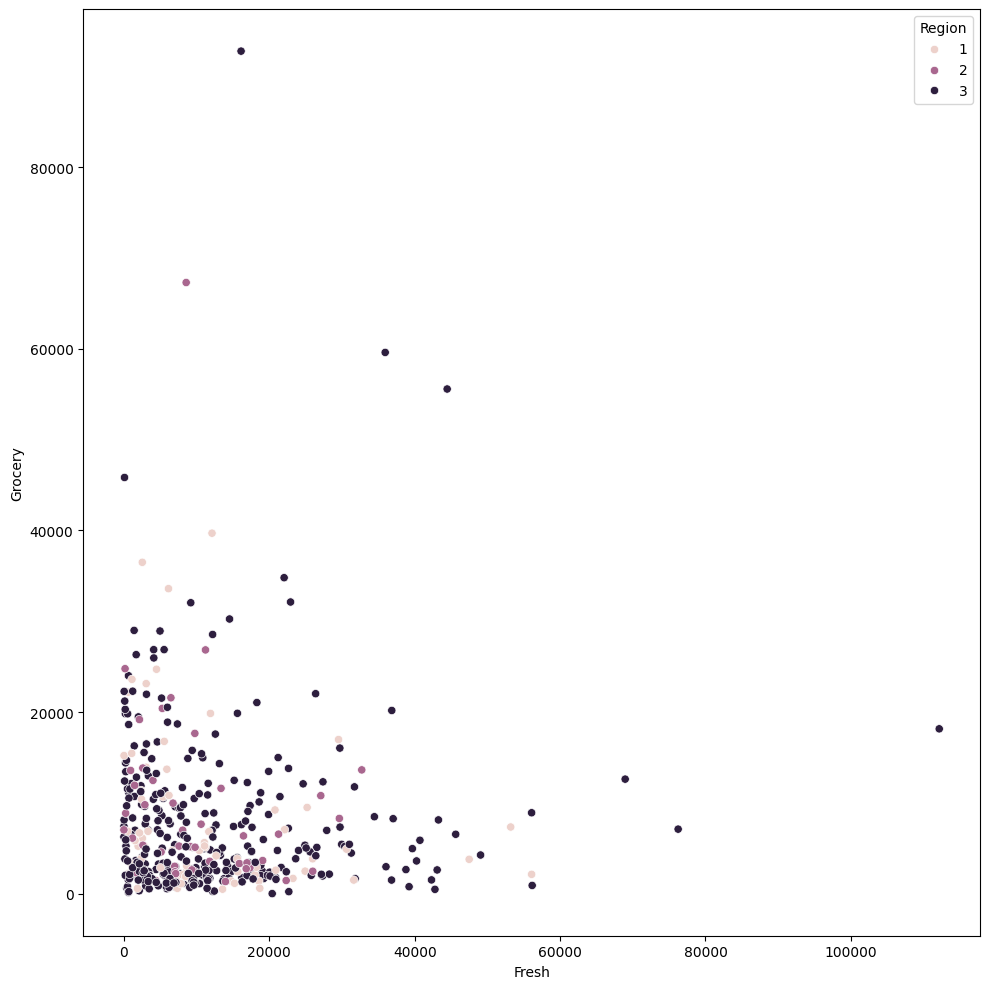

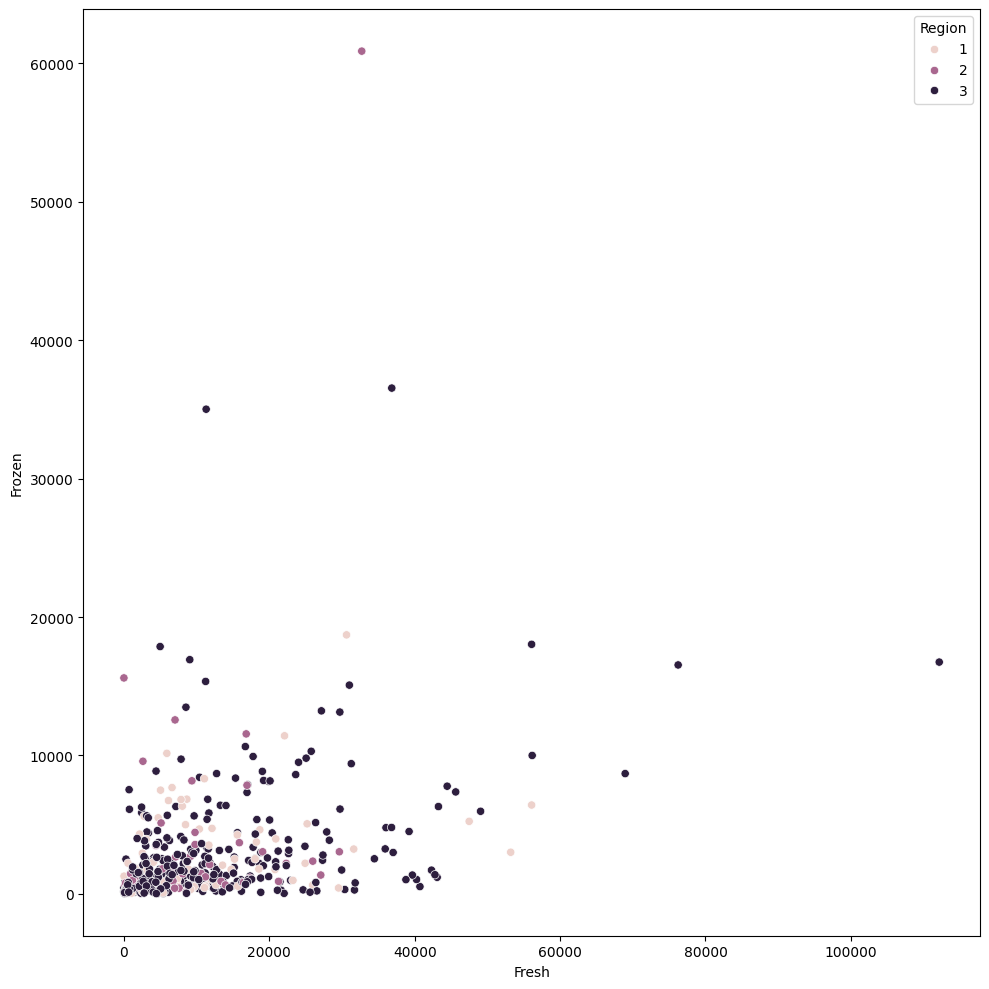

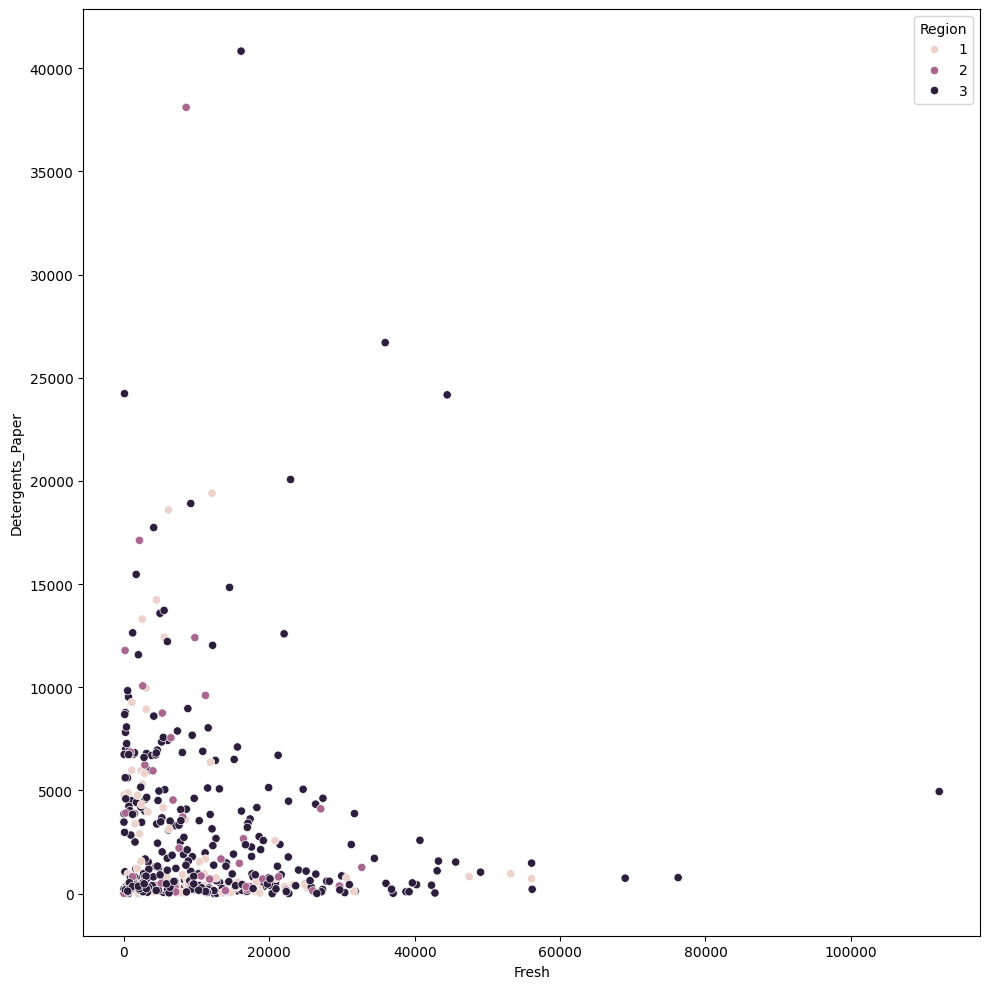

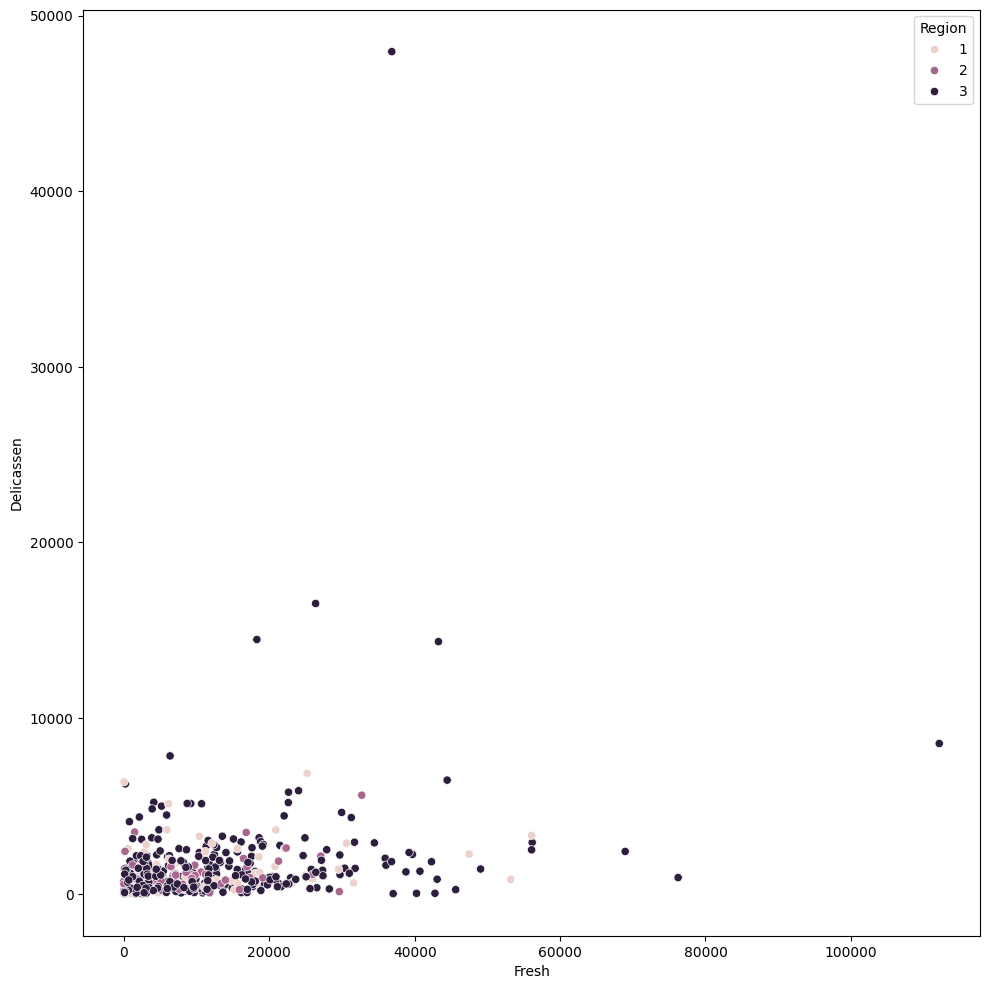

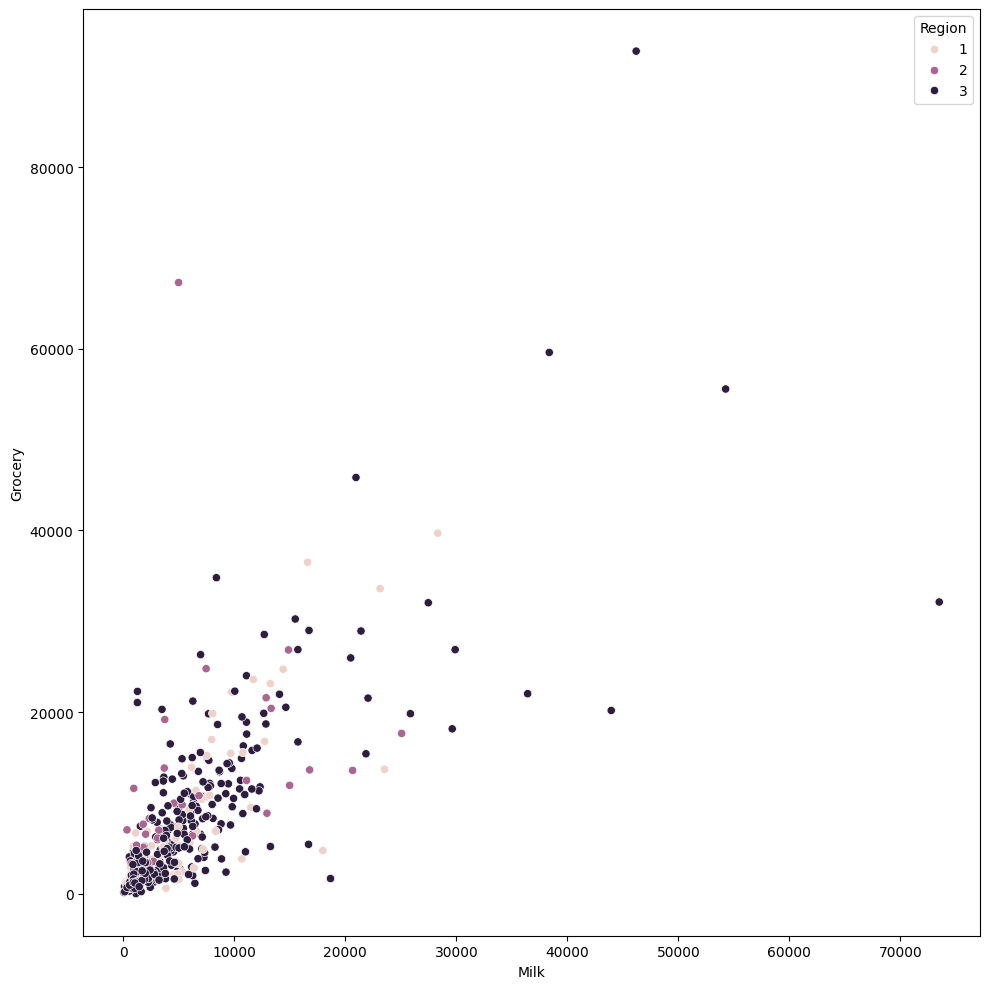

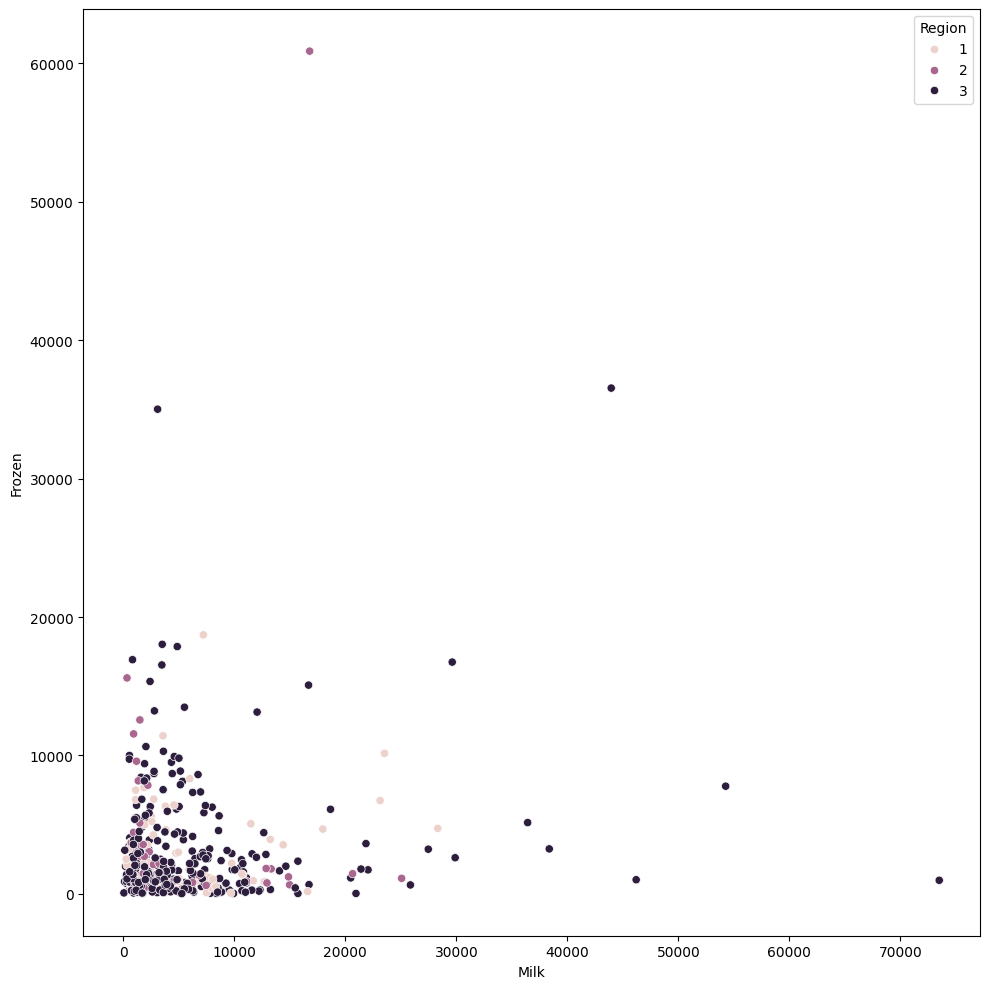

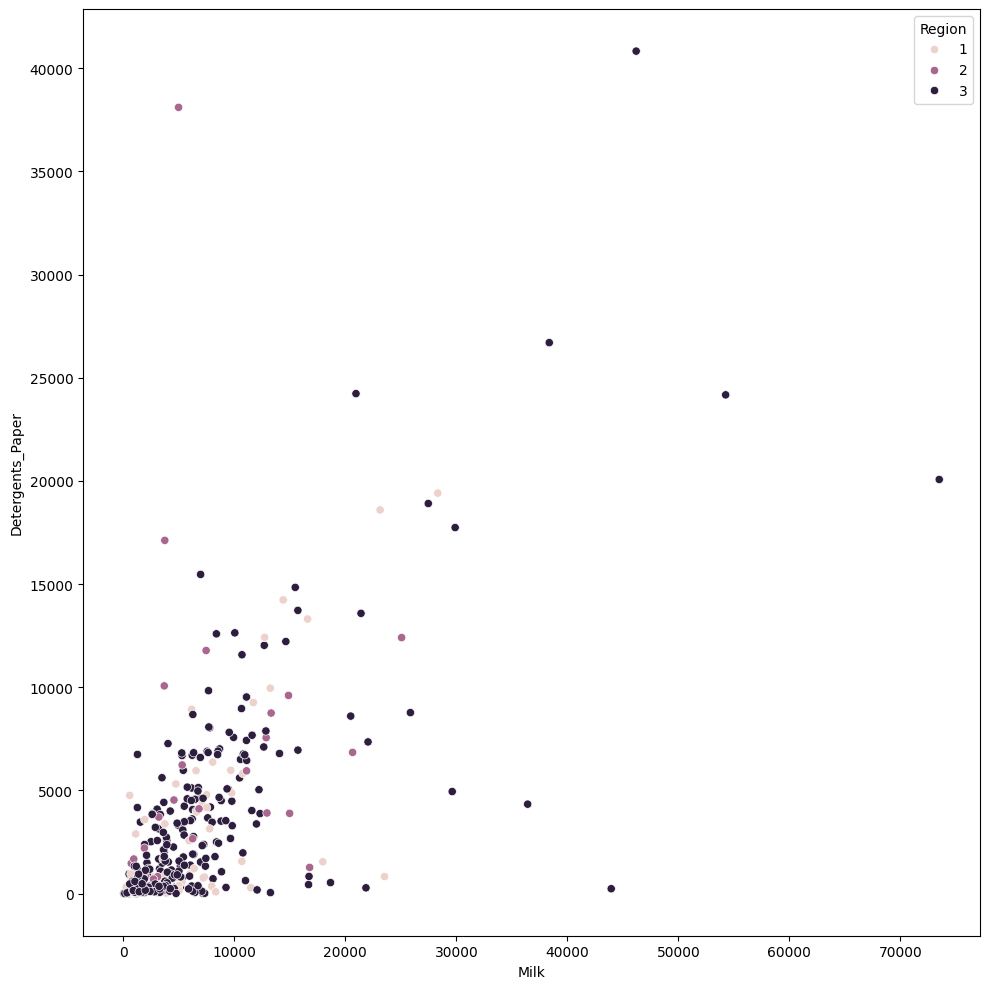

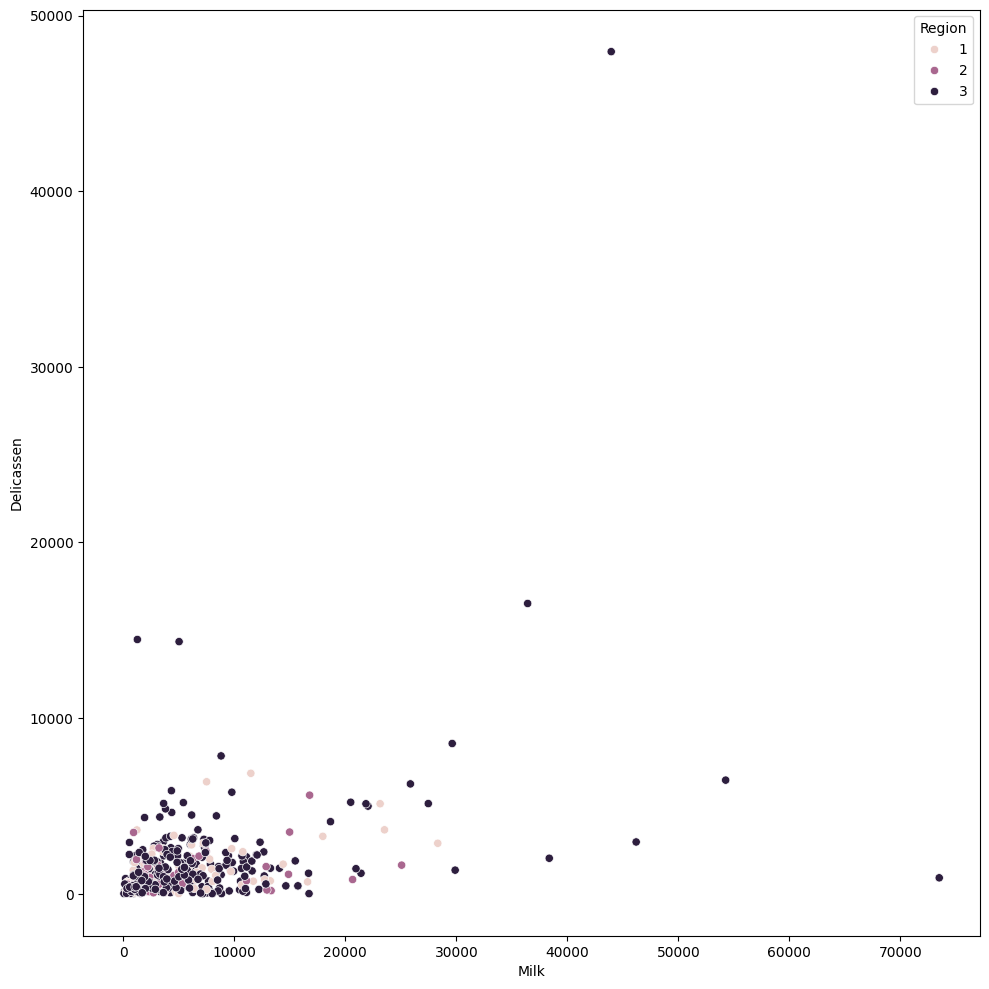

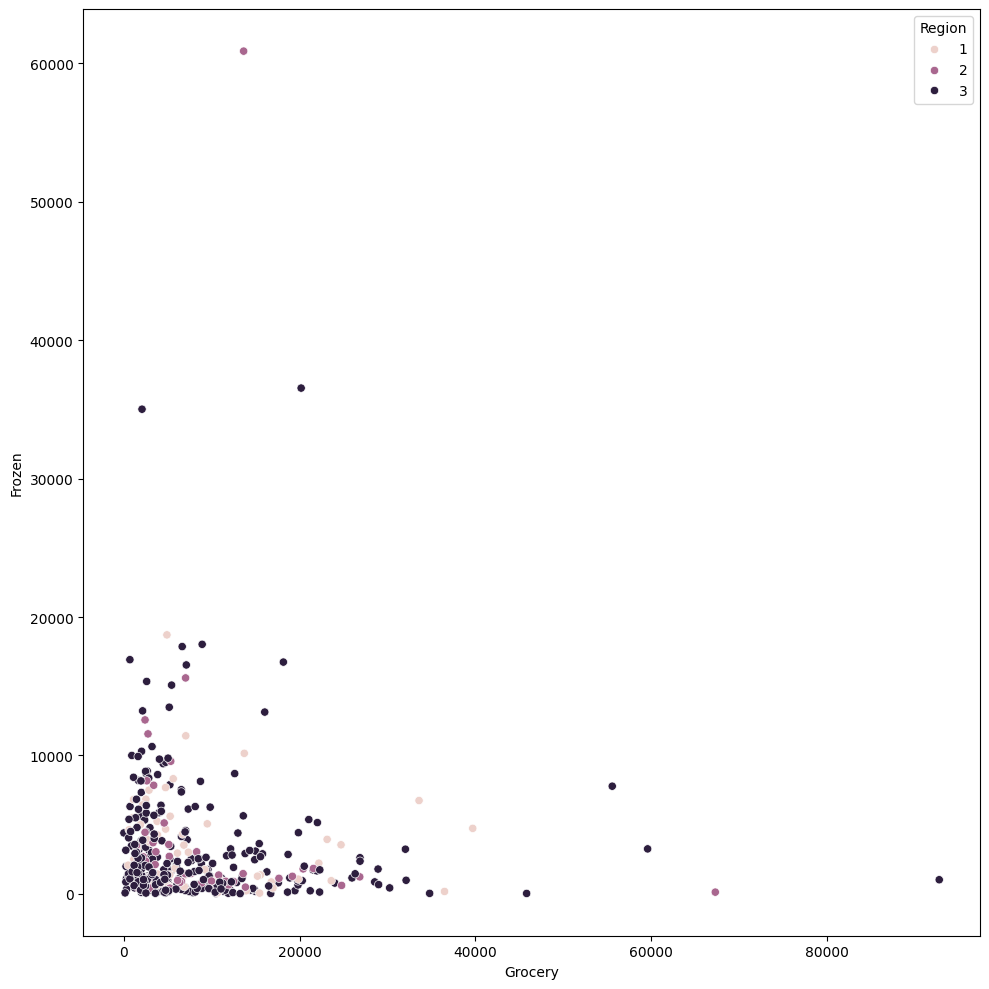

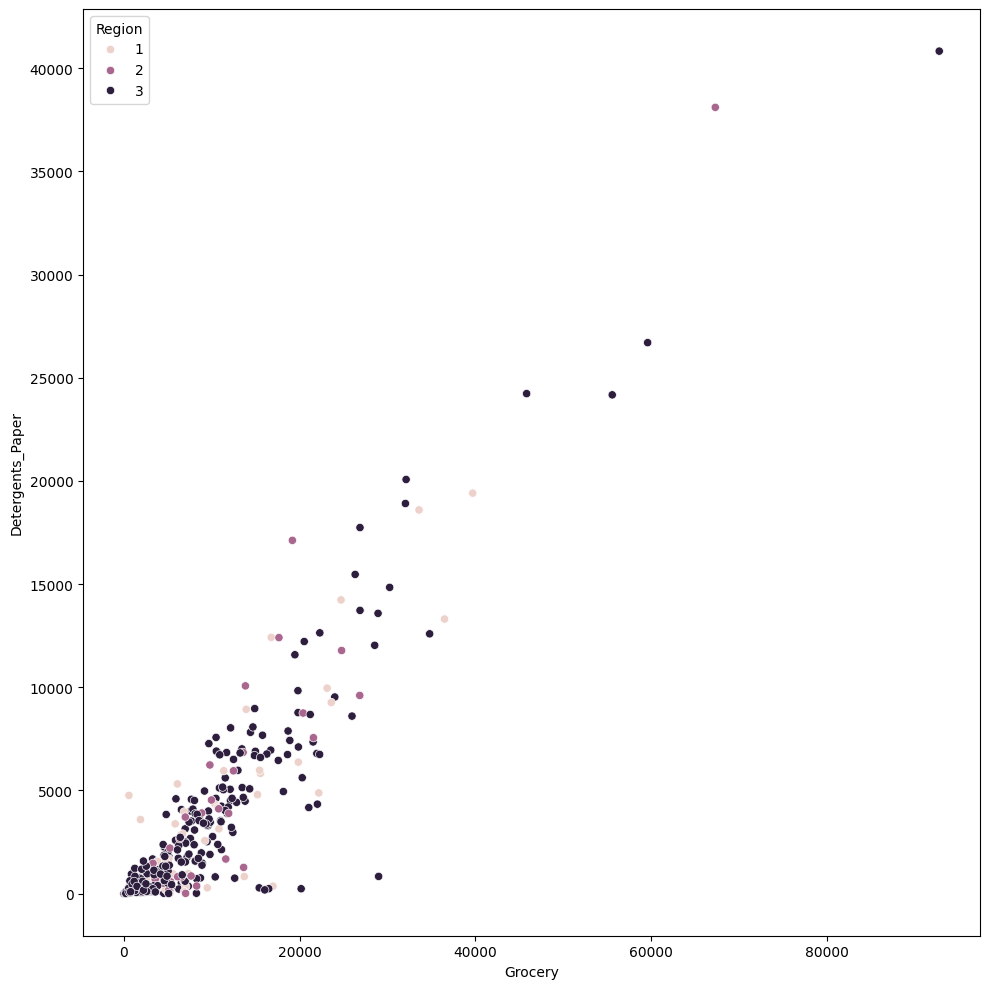

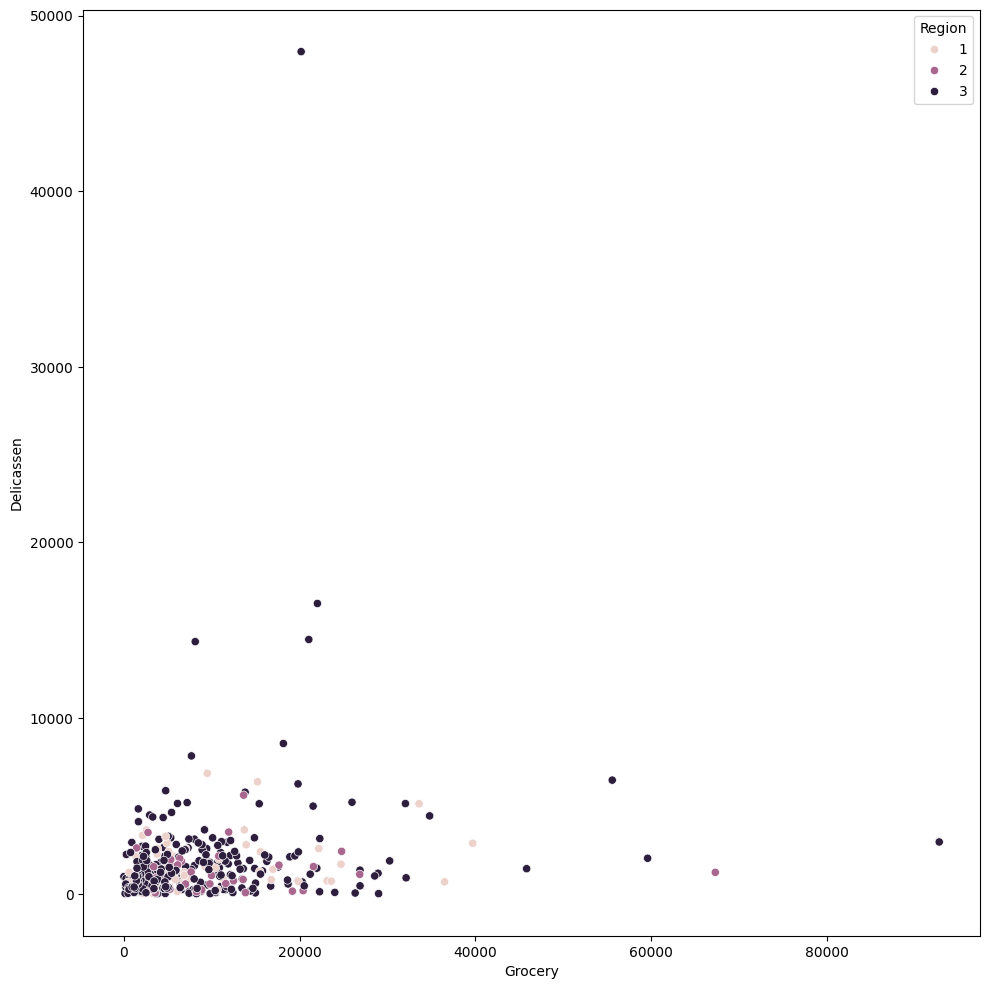

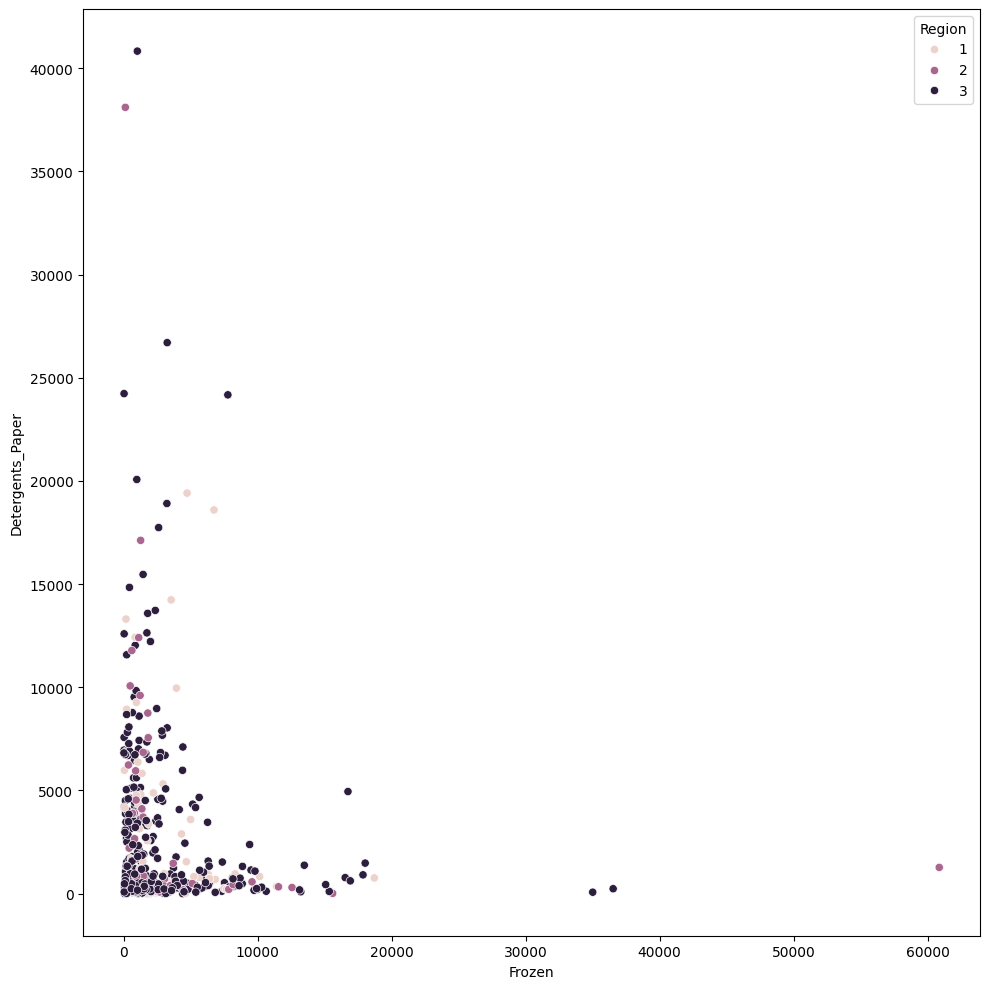

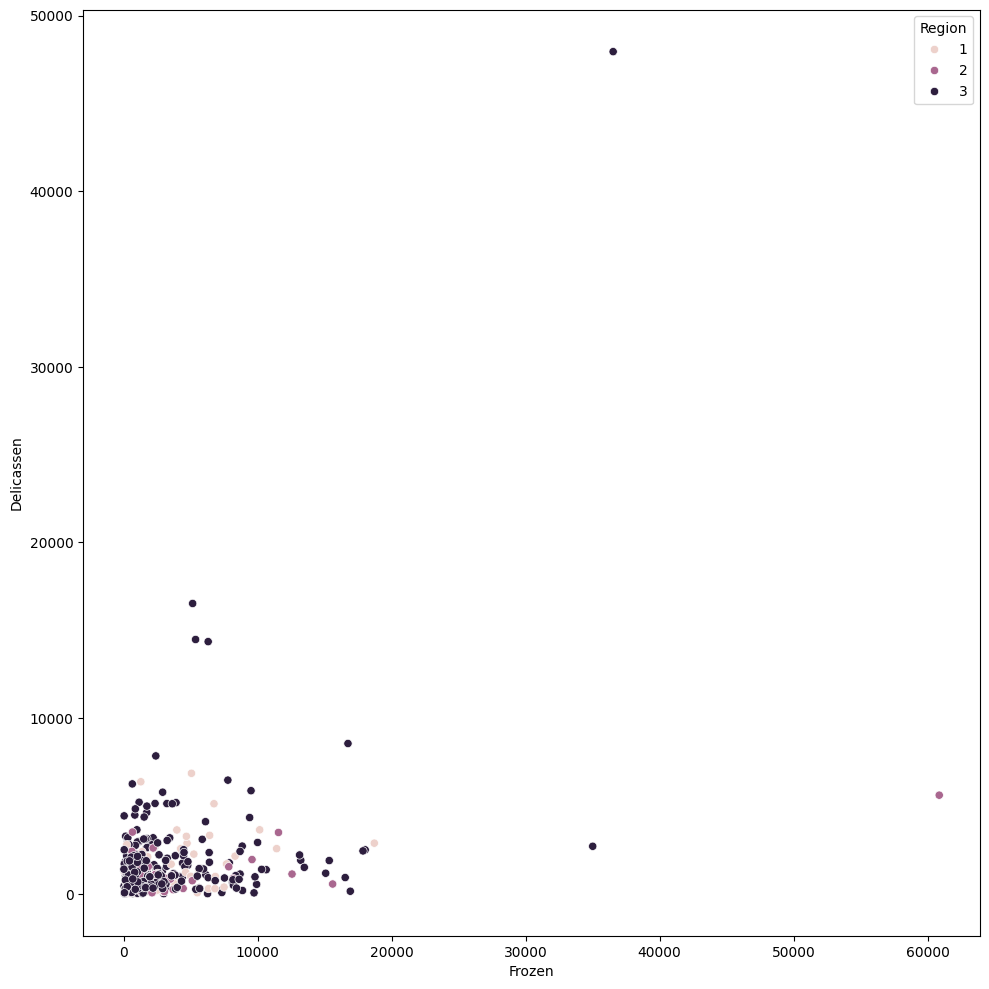

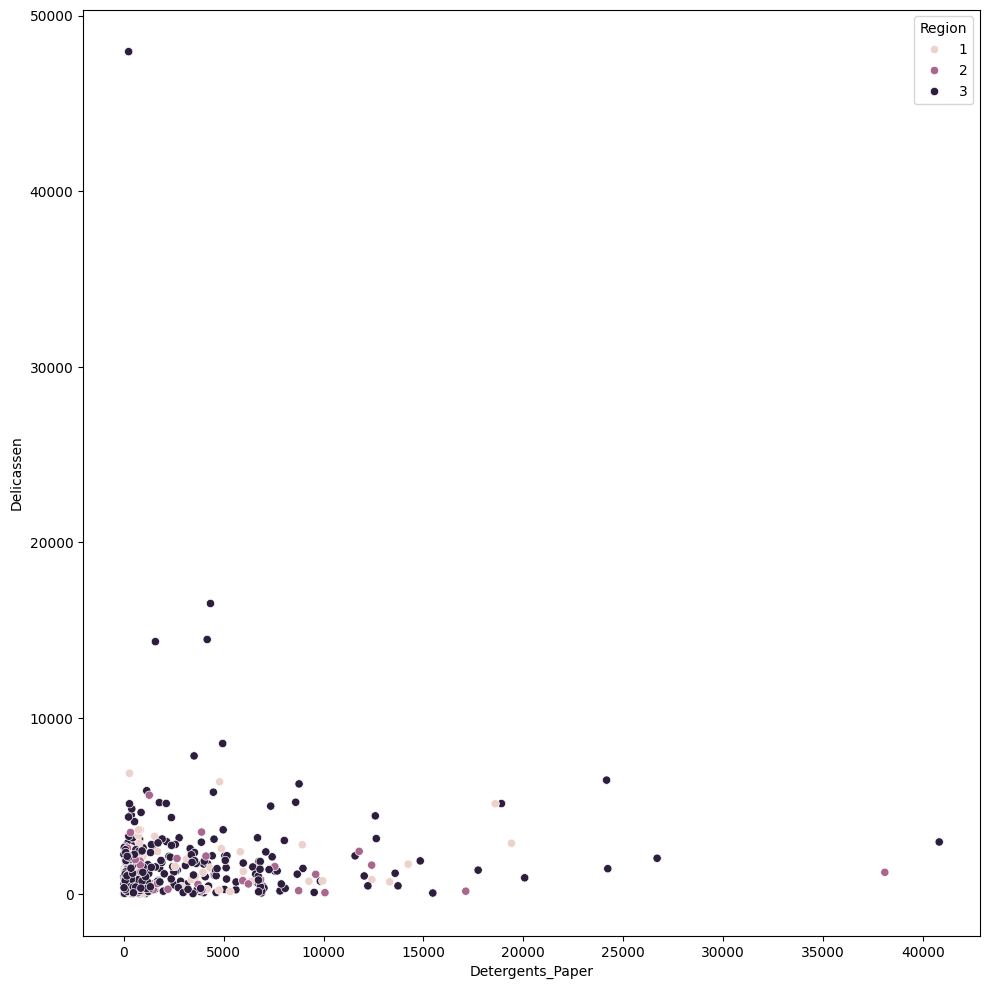

In [15]:
for hue in cat_cols:
    for x in range(0,len(num_cols)):
        for y in range(x+1,len(num_cols)):
            plt.figure(figsize=(10,10))
            sns.scatterplot(data=df,x=num_cols[x],y=num_cols[y],hue=hue)
            plt.xlabel(xlabel=num_cols[x])
            plt.ylabel(ylabel=num_cols[y])
            plt.tight_layout()
            plt.show()


**Consideration**
- There are some columns that have correlated relationship for data extraction
- There are a lot of outliers and removing it is the best way to empower the model

<font size='10'> Cleaning data<font>

<font size='5'>Outlier</font>

In [16]:
def outlier(dataframe,col):
    quantile1=dataframe[col].quantile(0.05)
    quantile3=dataframe[col].quantile(0.95)
    distance= quantile3-quantile1
    low_limit=quantile1-distance*1.5
    up_limit=quantile3+distance*1.5

    return low_limit,up_limit
    

In [17]:
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [18]:
for col in num_cols:
    print(col,check_outlier(df,col))

Fresh True
Milk True
Grocery True
Frozen True
Detergents_Paper True
Delicassen True


In [19]:
print(df.iloc[23].index)



Index(['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen',
       'Detergents_Paper', 'Delicassen'],
      dtype='object')


In [20]:
# for col in num_cols:
#     low_limit,up_limit=outlier(df,col)
#     df=df[(df[col]>=low_limit) & df[col]<=up_limit]
    

In [21]:
df.shape

(440, 8)

<font size='5'>Missing value</font>

- No any missing values
df.isnull().sum()

<font size='10'>Feature Engineering</font>

<font size='5'>Feature Extraction</font>

In [22]:

# df['Fresh_Milk']=df.Fresh*df.Milk

# df['Fresh_Grocery']=df.Fresh*df.Grocery

# df['Fresh_Detergents_Paper']=df.Fresh*df.Detergents_Paper

# df['Milk_Grocery']=df.Milk*df.Grocery

# df['Milk_Frozen']=df.Milk*df.Frozen

# df['Milk_Detergents_Paper']=df.Milk*df.Detergents_Paper

# df['Grocery_Frozen']= df.Grocery*df.Frozen

# df['Grocery_Detergents_Paper']= df.Grocery*df.Detergents_Paper

# df['Grocery_Delicassen']= df.Grocery*df.Detergents_Paper

# df['Frozen_Detergents_Paper']= df.Frozen*df.Detergents_Paper

<font size='5'>Remove highly-correlated variables</font>

In [23]:
def highly_correlated_features(dataframe,num_cols, th=0.9):
    corr= dataframe[num_cols].corr()
    corr_matrix=corr.abs()
    upper_triangle_matrix=corr_matrix.where(np.triu(np.one(corr_matrix.shape),k=1).astype(bool))

    highly_correlated_cols=set()
    for col in upper_triangle_matrix.columns:
        print(upper_triangle_matrix[col])
        if any(upper_triangle_matrix[col])>=th:
            highly_correlated_cols.add(col)
    return list(highly_correlated_cols)

In [24]:
# df.drop(columns=highly_correlated_features(df,num_cols),axis=1,inplace=True)

<font size='5'>Data Scaling</font>

In [25]:
scaler=StandardScaler()

df[num_cols]=scaler.fit_transform(df[num_cols])

<font size='5'>One-hot encoding</font>

In [26]:
# df=pd.get_dummies(df,columns=cat_cols,drop_first=True,dtype=int)

<font size='10'>Modeling</font>

<font size='5'>PCA</font>

In [27]:
pca=PCA()


In [41]:
pcomps = pca.fit_transform(df)
pcomps.shape

(440, 8)

In [43]:
pcomps

array([[ 0.3254359 , -0.35229303, -0.21915054, ...,  0.43829917,
        -0.60856592,  0.04006222],
       [ 0.56330442, -0.36382535,  0.24703435, ...,  0.31187744,
        -0.54912564,  0.09781803],
       [ 0.8994455 ,  0.78889553,  1.41168183, ..., -0.43217428,
        -0.5636636 , -0.23308256],
       ...,
       [ 3.56830986, -0.91621212, -0.76353379, ..., -0.53462916,
         0.10530891, -0.09182223],
       [-0.9523954 , -0.02961277,  0.17578934, ..., -0.08528611,
         0.19241327, -0.0443229 ],
       [-1.11063862, -0.8642129 ,  0.23120257, ...,  0.12122413,
         0.24015209,  0.00983962]])

In [44]:
eigen_values = pca.explained_variance_
eigen_vector = pca.components_
print("Eigen values : \n",eigen_values)
print("Eigen vector : \n",eigen_vector)

Eigen values : 
 [2.73120689 1.72744813 0.74423507 0.62742316 0.53448843 0.28742405
 0.11723501 0.06277679]
Eigen vector : 
 [[ 1.76618046e-01  1.34842877e-02  2.55938084e-02  5.32839024e-01
   5.74444428e-01  3.04584435e-02  5.48164233e-01  2.29463780e-01]
 [-1.07193111e-01  2.70901588e-02  5.26887238e-01  1.11236616e-01
  -1.15680595e-01  6.08789201e-01 -2.26010863e-01  5.12547375e-01]
 [-6.61744375e-04 -1.34283925e-01 -8.09759264e-01  5.68274010e-02
  -1.02766399e-01  2.04694171e-01 -1.28579206e-01  5.04018572e-01]
 [-3.99605517e-02 -8.09056862e-01 -2.01477554e-02 -5.71107209e-02
   8.75348828e-02  4.27920387e-01  1.26590734e-01 -3.65183727e-01]
 [ 1.74307600e-02  5.69447077e-01 -2.42667076e-01 -6.37994080e-02
   7.27956640e-02  6.30583942e-01  1.26545635e-01 -4.39908407e-01]
 [-8.30829149e-02 -1.57444522e-02 -5.23409348e-02  8.31501163e-01
  -3.02391358e-01 -3.67836854e-02 -3.28805914e-01 -3.12743796e-01]
 [-9.70882472e-01  4.41451838e-02 -5.45367381e-02  1.14752364e-02
   1.970208

([<matplotlib.patches.Wedge at 0x2079ce34fb0>,
 [Text(0.34073056706980553, 1.0458980259395698, 'PC1'),
  Text(-1.0851607201831792, -0.18007279464573167, 'PC2'),
  Text(-0.2932208979935139, -1.0601988044606905, 'PC3'),
  Text(0.38841548119906383, -1.0291420766662394, 'PC4'),
  Text(0.8583379077973962, -0.6879360697317658, 'PC5'),
  Text(1.051612289302265, -0.3226632811282525, 'PC6'),
  Text(1.0931523766116789, -0.12254746634769102, 'PC7'),
  Text(1.0995417564494467, -0.031747847550119744, 'PC8')],
 [Text(0.18585303658353028, 0.5704898323306743, '39.98%'),
  Text(-0.5919058473726432, -0.09822152435221726, '25.28%'),
  Text(-0.15993867163282574, -0.5782902569785584, '10.89%'),
  Text(0.21186298974494389, -0.5613502236361305, '9.18%'),
  Text(0.4681843133440342, -0.3752378562173268, '7.82%'),
  Text(0.5736067032557808, -0.17599815334268318, '4.21%'),
  Text(0.5962649326972793, -0.066844072553286, '1.72%'),
  Text(0.5997500489724255, -0.01731700775461077, '0.92%')])

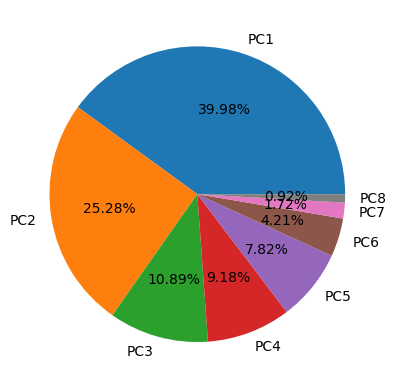

In [46]:
plt.pie(x =eigen_values,labels=["PC1","PC2","PC3","PC4","PC5","PC6","PC7",'PC8'],autopct="%.2f%%")

**Validation**

In [48]:
pcomps_res = np.dot(df,eigen_vector.T)
pcomps_res

array([[ 5.93346399e-01, -4.25185083e-01, -5.61534285e-01, ...,
         2.88362123e-01, -1.78050941e+00,  1.32677384e-01],
       [ 8.31214918e-01, -4.36717397e-01, -9.53493975e-02, ...,
         1.61940396e-01, -1.72106914e+00,  1.90433188e-01],
       [ 1.16735600e+00,  7.16003474e-01,  1.06929809e+00, ...,
        -5.82111324e-01, -1.73560710e+00, -1.40467394e-01],
       ...,
       [ 3.83622036e+00, -9.89104176e-01, -1.10591753e+00, ...,
        -6.84566200e-01, -1.06663459e+00,  7.92931736e-04],
       [-6.84484901e-01, -1.02504818e-01, -1.66594408e-01, ...,
        -2.35223152e-01, -9.79530228e-01,  4.82922646e-02],
       [-8.42728114e-01, -9.37104949e-01, -1.11181175e-01, ...,
        -2.87129138e-02, -9.31791403e-01,  1.02454786e-01]])

In [50]:
pca_df = pd.DataFrame(pcomps,columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8"])
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.325436,-0.352293,-0.219151,-0.664715,-0.125278,0.438299,-0.608566,0.040062
1,0.563304,-0.363825,0.247034,-0.542173,0.145930,0.311877,-0.549126,0.097818
2,0.899446,0.788896,1.411682,-1.274648,-0.704407,-0.432174,-0.563664,-0.233083
3,-0.837467,0.654653,0.114571,-0.160659,0.570535,-0.276210,0.152060,0.048870
4,0.250098,1.210076,-0.016703,-0.847000,-0.425702,-0.463514,-0.716412,0.030120


<font size='5'>K-Means</font>

In [30]:
kmeans = KMeans(n_clusters=2, init='k-means++') # ‘k-means++’ : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence.
kmeans.fit(df)

KMeans(n_clusters=2)

In [31]:
kmeans.inertia_

2300.989140897534

**Elbow method**

Text(0, 0.5, 'Inertia')

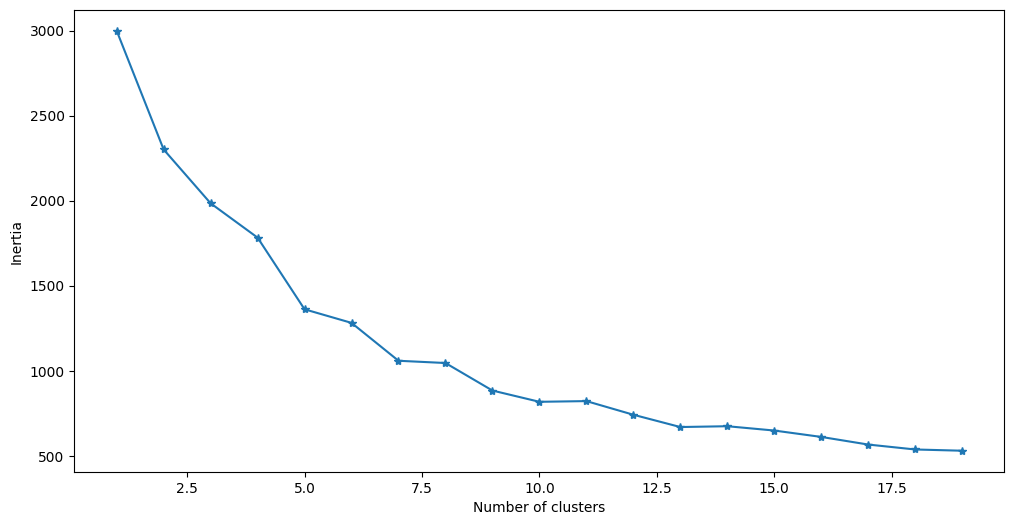

In [32]:
SSE = []
for i in range(1,20):
    kmeans = KMeans(n_clusters = i, init='k-means++') # iterate from range (1, 20)
    kmeans.fit(df)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker="*")
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [33]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(df)
pred = kmeans.predict(df)
pred

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 4, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 4, 0, 0, 1, 1, 1, 0, 1, 1, 4, 0, 1, 1, 0, 4, 0, 0, 1, 4,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 2, 4, 1,
       1, 1, 1, 1, 4, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 4, 0, 3, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 4, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,

In [34]:
frame = pd.DataFrame(df)
frame['cluster'] = pred
frame['cluster'].value_counts()

cluster
1    304
0    123
4     10
2      2
3      1
Name: count, dtype: int64

**Consideration**
- The data points are distributed effectively

<font size='5'>DBSCAN</font>

In [52]:
dbscan = DBSCAN(eps=1)
dbscan.fit(df)
labels_dbscan = dbscan.labels_

In [58]:
dbscan.labels_

array([ 0,  0, -1,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,
        1,  0,  1,  0,  1, -1, -1, -1,  0,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  0,  1,  0,  0, -1, -1,  1,  0,  0,  0, -1,  0, -1,  0, -1,  1,
        1, -1,  0,  1,  1, -1,  0,  1,  1,  0, -1,  0,  0,  1, -1,  1,  0,
        1,  1,  1, -1,  1, -1,  0,  1,  1, -1,  1,  1,  1,  0,  0,  1,  0,
       -1, -1, -1,  1,  1,  1,  1, -1, -1,  0,  1,  0,  1,  1,  1,  0,  0,
        0, -1,  1,  1,  0,  0,  0, -1,  1,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  0,  1, -1,  1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  0,  0,  1,  0,  0,  0,  1,  1,  0,  0,  0,  0,  1,  1,  1,
        0, -1,  1,  0,  1,  0, -1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,
        1,  0,  0,  1,  1,  1,  0,  1,  1, -1,  3,  2,  2, -1, -1, -1,  2,
        2, -1,  2,  3,  2, -1,  2, -1,  2,  2,  3,  2, -1,  2, -1,  2,  2,
        2,  2, -1,  2,  2

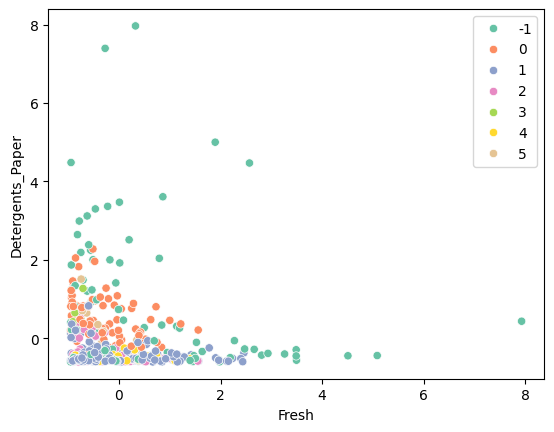

In [74]:
sns.scatterplot(x=df.Fresh, y=df.Detergents_Paper, hue=labels_dbscan, palette='Set2')
plt.show()

**Consideration**
- The dataset is clustered ineffectively
- There are a lot of noises which are labeled "-1"
- The clusters are likely overlapping or adjacent in the feature space, making it challenging to distinguish them visually.

<font size='5'>Hierarchical</font>

In [38]:
model=AgglomerativeClustering(n_clusters=3,metric='euclidean',linkage='ward')

model.fit(df)
labels=model.labels_

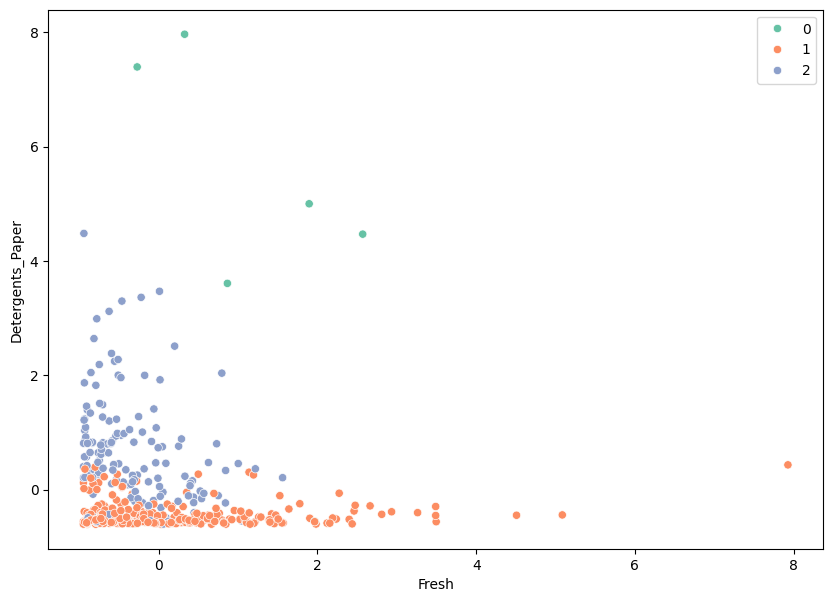

In [75]:
plt.figure(figsize=(10,7))
sns.scatterplot(x=df.Fresh, y=df.Detergents_Paper, hue=labels, palette='Set2')
plt.legend()
plt.show()

**Consideration**
- The clustering seems to be effective in distinguishing between dense regions of data
- These points are farther from the dense regions, indicating that they might be outliers or data points with distinct characteristics.

<font size='5'>**Conclusion**</font>

The optimal model that we can choose is **Hierarchical**

<font size='10'>Suggestion</font>

- More data visualizations to get insights of the dataset
- The outliers should be removed
- Need to have feature extraction to empower the clustering ability of the model 